In [ ]:
# default_exp face_cropped_training

In [1]:
#export
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET
from torch.autograd import Variable
from fastai.callbacks import LossMetrics
from pathlib import Path

In [2]:
#export
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
#export
from facelib.face_dataset_unlabeled import create_cropped_data, config

In [5]:
#export
df, filename2label = create_cropped_data()
df.head()

,image_path,valid,dataset
0,../data/face/unlabeled_cropped_images/AbdA_000...,False,unlabeled_cropped
1,../data/face/unlabeled_cropped_images/AbdA_000...,False,unlabeled_cropped
2,../data/face/unlabeled_cropped_images/AbdA_000...,False,unlabeled_cropped
3,../data/face/unlabeled_cropped_images/AbdA_000...,False,unlabeled_cropped
4,../data/face/unlabeled_cropped_images/AbdA_000...,False,unlabeled_cropped


In [6]:
#export
get_random_color = lambda: tuple(np.random.choice(range(256), size=3))
pretty_colors = [(255, 0, 0), (255, 63, 0), (255, 127, 0), (255, 191, 0), (255, 255, 0), (191, 255, 0), (127, 255, 0), (63, 255, 0), (0, 255, 0), (0, 255, 63), (0, 255, 127), (0, 255, 191), (0, 255, 255), (0, 191, 255), (0, 127, 255), (0, 63, 255), (0, 0, 255), (63, 0, 255), (127, 0, 255), (191, 0, 255), (255, 0, 255), (255, 0, 191), (255, 0, 127), (255, 0, 63)]
# fpoint_colors = (pretty_colors * 3)[:68]
fpoint_colors = [get_random_color() for i in range(68)]
# fpoint_colors = [(255,0,0) for i in range(68)]

In [7]:
#export
rgb2hex = lambda r,g,b: '#%02x%02x%02x' % (r,g,b)
fpoint_colors = list(map(lambda x: rgb2hex(*x), fpoint_colors))

# Databunch

In [8]:
#export
binary_predictions = [
('Age', 0.35),
('BackgroundUniformity', 0.5),
('BeardConfidence', 0.5),
('BlinkConfidence', 0.6),
('Contrast', 0.8),
('DarkGlassesConfidence', 0.5),
('DetectionConfidence', 0.65),
('EmotionSadnessConfidence', 0.01),
('EmotionFearConfidence', 0.01),
('EmotionContemptConfidence', 0.01),
('EmotionNeutralConfidence', 0.01),
('EmotionSurpriseConfidence', 0.01),
('EmotionDisgustConfidence', 0.01),
('EmotionAngerConfidence', 0.01),
('EmotionHappinessConfidence', 0.5),
('EthnicityAsianConfidence', 0.1),
('EthnicityBlackConfidence', 0.05),
('EthnicityHispanicConfidence', 0.1),
('EthnicityIndianConfidence', 0.05),
('EthnicityWhiteConfidence', 0.6),
('ExpressionConfidence', 0.6),
# ('FaceDarknessConfidence', 0.9),
# ('GenderConfidence', 0.25),
# ('GlassesConfidence', 0.4),
# ('GlassesReflectionConfidence', 0.99),
# ('GrayscaleDensity', 0.8),
# ('HatConfidence', 0.4),
# ('LookingAwayConfidence', 0.65),
# ('MouthOpenConfidence', 0.6),
# ('MustacheConfidence', 0.5),
# ('Noise', 0.8),
# ('PixelationConfidence', 0.99),
# ('Quality', 0.9),
# ('RedEyeConfidence', 0.99),
# ('Saturation', 1),
# ('Sharpness', 0.75),
# ('SkinReflectionConfidence', 0.4),
# ('UnnaturalSkinToneConfidence', 0.55),
# ('WashedOutConfidence', 0.95)
]

float_predictions = [
('Yaw', 0.05, 8.47),
('Roll', -1.01, 6.59),
('Pitch', -8.44, 6.09),
]

float_names = list(map(lambda x:x[0], float_predictions))
bin_names = list(map(lambda x:x[0], binary_predictions))

float_stats = torch.tensor([[mean, std] for name, mean, std in float_predictions])
bin_stats = torch.tensor([[mean, 1] for name, mean in binary_predictions])

In [9]:
#export
def process_bin_name(name):
    return name.replace('Ethnicity', 'Et').replace('Emotion', 'Em').replace('Glasses', 'Gls')

In [10]:
#export
INPUT_SHAPE = [224,224]

In [11]:
#export
def path2bb(path):
    fn = path.split(os.path.sep)[-1]
    label = filename2label[fn]
    fpoints = tensor(label['FeaturePoints'])
    scalars = label['Scalars']
    c = lambda x: torch.clamp(x, 0, 1)
#     bin_values = [c(scalars[n] - (mean-0.5)) for n, (mean,std) in zip(bin_names, bin_stats)] # normalized to have mean of 0.5
    bin_values = [scalars[ bpred[0] ] for n, (mean,std), bpred in zip(bin_names, bin_stats, binary_predictions)]
    float_values = [scalars[n] for n in float_names]
    other_data = (tensor(bin_values), tensor(float_values))
    return fpoints, other_data

In [12]:
#export
class MyImagePoints(ImagePoints):
    "Support applying transforms to a `flow` of points."
    def __init__(self, flow, scale=True, y_first=True, other_data=None):
        super().__init__(flow, scale, y_first)
        self.other_data = other_data

    def clone(self):
        "Mimic the behavior of torch.clone for `ImagePoints` objects."
        return self.__class__(FlowField(self.size, self.flow.flow.clone()), scale=False, y_first=False, other_data=self.other_data)

    def show(self, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True, **kwargs):
        "Show the `ImagePoints` on `ax`."
        if ax is None: _,ax = plt.subplots(figsize=figsize)
        pnt = scale_flow(FlowField(self.size, self.data), to_unit=False).flow.flip(1)
        params = {'s': 20, 'marker': '.', **kwargs}
        for (y,x),color in zip(pnt, fpoint_colors):
            ax.scatter(y, x, color=color, **params)
        if hide_axis: ax.axis('off')
        bin_vals, float_vals = map(list, self.other_data)
        preds, values = bin_names + float_names, bin_vals + float_vals
        values = map(lambda v: str(int(v*100)/100), values)
        text = '\n'.join([ k+'  '+str(v) for k,v in zip(preds,values) ])
        ax.set_title(text)

In [13]:
#export
class PointsProcessor(PreProcessor):
    "`PreProcessor` that stores the number of targets for point regression."
    def __init__(self, ds:ItemList): self.c = len(ds.items[0].reshape(-1))
    def process(self, ds:ItemList):  ds.c = self.c

In [14]:
#export
def _get_size(xs,i):
    size = xs.sizes.get(i,None)
    if size is None: # Image hasn't been accessed yet, so we don't know its size
        _ = xs[i]
        size = xs.sizes[i]
    return size

class MyPointsLabelList(ItemList):
    "`ItemList` for points."
    _processor = PointsProcessor
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        self.loss_func = MSELossFlat()

    def get(self, i):
        fpoints, other_data = super().get(i)
        return MyImagePoints(FlowField(_get_size(self.x,i), fpoints), scale=True, other_data=other_data)

    def analyze_pred(self, pred, thresh:float=0.5): return [pred[0].view(-1,2)] + pred[1:]
    def reconstruct(self, t, x):
        fpts, *other_data = t
        return MyImagePoints(FlowField(x.size, fpts), scale=False, other_data=other_data)

In [15]:
#export
class MyPointsItemList(ImageList):
    "`ItemList` for `Image` to `ImagePoints` tasks."
    _label_cls,_square_show_res = MyPointsLabelList,False

In [16]:
#export
def create_src():
    return (MyPointsItemList.from_df(df, path='../models', cols='image_path')
#                       .split_from_df('valid')
                      .split_by_rand_pct(0.1)
                      .label_from_func(path2bb)
            )

In [17]:
src = create_src()
src

LabelLists;

Train: LabelList (126860 items)
x: MyPointsItemList
Image (3, 120, 116),Image (3, 121, 116),Image (3, 125, 123),Image (3, 125, 120),Image (3, 136, 134)
y: MyPointsLabelList
MyImagePoints (120, 116),MyImagePoints (121, 116),MyImagePoints (125, 123),MyImagePoints (125, 120),MyImagePoints (136, 134)
Path: ../models;

Valid: LabelList (14095 items)
x: MyPointsItemList
Image (3, 161, 163),Image (3, 333, 349),Image (3, 119, 114),Image (3, 153, 155),Image (3, 147, 140)
y: MyPointsLabelList
MyImagePoints (161, 163),MyImagePoints (333, 349),MyImagePoints (119, 114),MyImagePoints (153, 155),MyImagePoints (147, 140)
Path: ../models;

Test: None

In [18]:
#export
def bb_pad_collate(samples:BatchSamples, pad_idx:int=0):
    if isinstance(samples[0][1], int): return data_collate(samples)
    max_len = max([len(s[1].data[1]) for s in samples])
    bin_true = torch.zeros(len(samples), len(bin_names))
    float_true = torch.zeros(len(samples), len(float_names))
    fpoints_true = torch.zeros(len(samples), 68,2)
    imgs = []
    for i, (image, point_obj) in enumerate(samples):
        c,h,w = image.shape
        fpoints = point_obj.data
        bin_values, float_values = point_obj.other_data
        imgs.append(image.data[None])
        bin_true[i] = bin_values
        float_true[i] = float_values
        fpoints_true[i] = fpoints #.view(68*2)
    images = torch.cat(imgs,0)
    return images, (fpoints_true, bin_true, float_true)

In [19]:
#export
train_transforms = [
    rotate(degrees=(-45, 45), p=0.5),
    symmetric_warp(magnitude=(-0.2, 0.2), p=0.5),
    rand_zoom(scale=(1.,1.2), p=0.8),
    brightness(change=(0.3, 0.7), p=0.5),
    contrast(scale=(0.7,1.3), p=0.5),
#     rand_crop(padding_mode='zeros')
]
valid_transforms = [
]

custom_transforms = (train_transforms,valid_transforms)

In [20]:
#export
train_transforms = [
    rotate(degrees=(-10, 10), p=0.5),
    symmetric_warp(magnitude=(-0.1, 0.1), p=0.5),
    rand_zoom(scale=(1.,1.1), p=0.8),
    brightness(change=(0.3, 0.7), p=0.5),
    contrast(scale=(0.7,1.3), p=0.5)
]
valid_transforms = [
]

simple_transforms = (train_transforms,valid_transforms)

In [21]:
#export
def create_data(src, size, bs=4, transforms=custom_transforms, padding='zeros'): # 'zeros'/'border'
    return (src.transform(transforms, size=size, padding_mode=padding, tfm_y=True, remove_out=False)
                        .databunch(bs=bs, collate_fn=bb_pad_collate)
                        .normalize(imagenet_stats)
    )

In [22]:
data = create_data(src, INPUT_SHAPE)
data

ImageDataBunch;

Train: LabelList (126860 items)
x: MyPointsItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MyPointsLabelList
MyImagePoints (224, 224),MyImagePoints (224, 224),MyImagePoints (224, 224),MyImagePoints (224, 224),MyImagePoints (224, 224)
Path: ../models;

Valid: LabelList (14095 items)
x: MyPointsItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MyPointsLabelList
MyImagePoints (224, 224),MyImagePoints (224, 224),MyImagePoints (224, 224),MyImagePoints (224, 224),MyImagePoints (224, 224)
Path: ../models;

Test: None

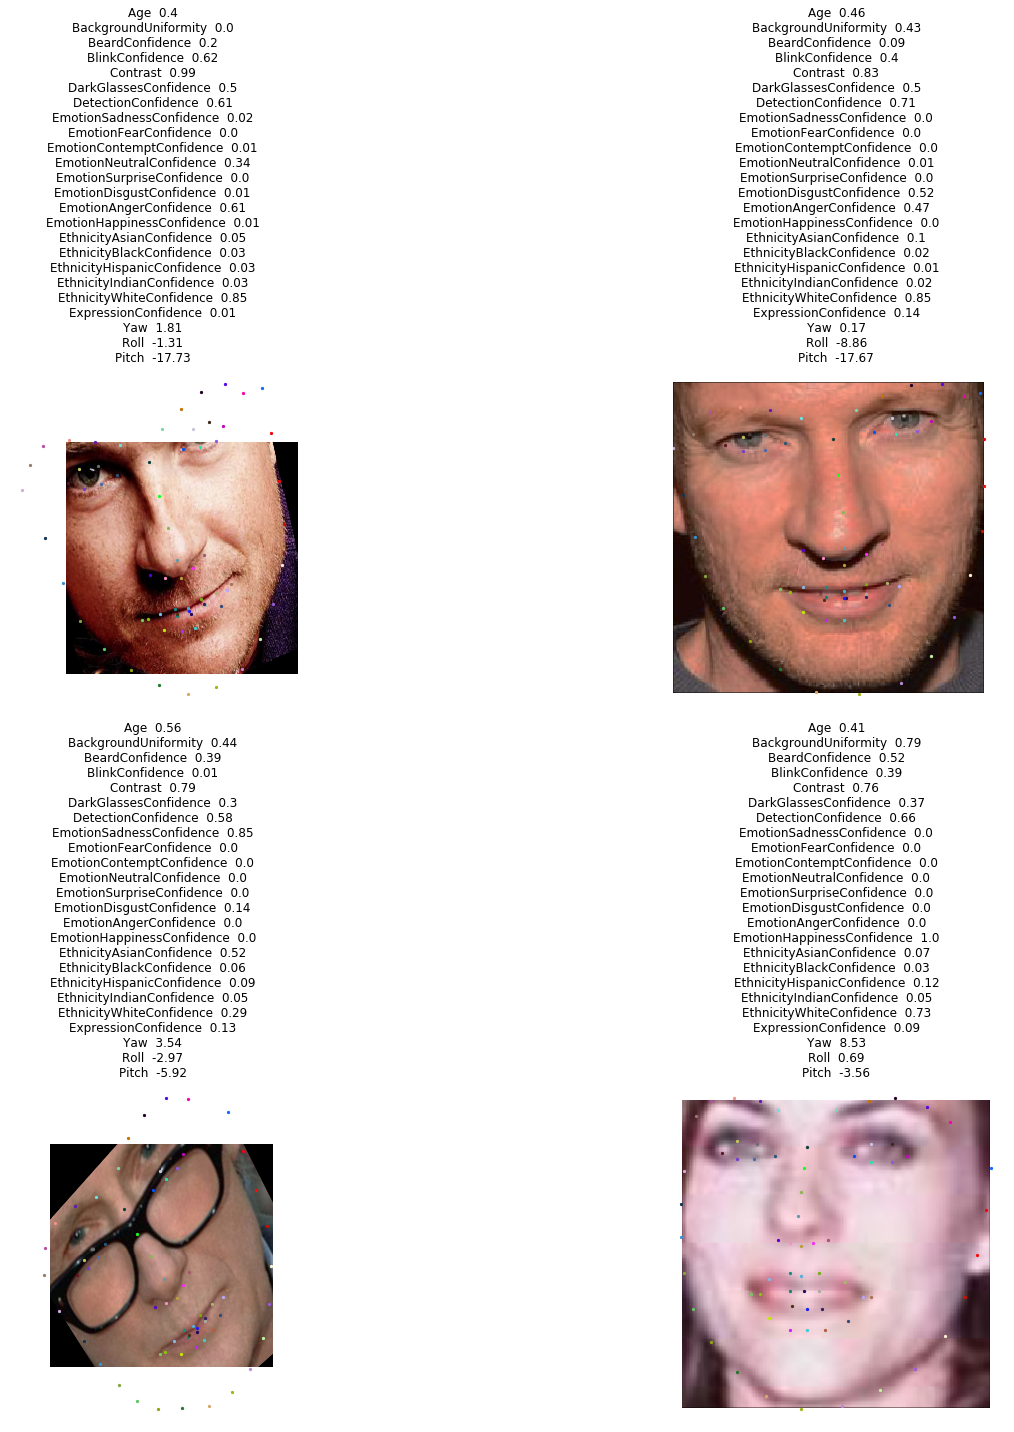

In [23]:
data.show_batch(figsize=(20,20))

In [24]:
#export
def freeze_layers(learner, layers):
    "Freeze layers for specific layer groups."
    for i, g in enumerate(learner.layer_groups):
        if i in layers: 
            for l in g:
                if not learner.train_bn or not isinstance(l, bn_types): requires_grad(l, False)
        else: requires_grad(g, True)
    learner.create_opt(defaults.lr)
    
def show_results(learner, *args, rows=1, figsize=(20,20), **kwargs):
    learner.show_results(*args, **kwargs, rows=rows, figsize=(figsize[0],figsize[1]*rows))

In [25]:
#export
def save_torch_inference(model, path):
    torch.save(model.state_dict(), path)
    
def load_torch_inference(model, path, device=torch.device('cpu')):
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

# Model

In [26]:
#export
from torchvision import models as torch_models

In [27]:
#export
imagenet_stats = torch.tensor(([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

class FaceModel(nn.Module):
    def __init__(self, num_bins, num_floats, float_stats, num_fpts=68*2, d_model=512, poolsize=(8,8)):
        # float_stats.shape = [num_floats, 2], where 2 = (mean, std)
        super().__init__()
        
        assert len(float_stats) == num_floats
        self.float_means = float_stats[:,0].reshape(1,-1)
        self.float_stds = float_stats[:,1].reshape(1,-1)

        resnet = torch_models.resnet18(pretrained=False)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        h,w = poolsize
        self.res_head = nn.Sequential(nn.BatchNorm2d(512), nn.AdaptiveAvgPool2d([h,w]), Flatten(),
                                      nn.Linear(h*w*512, d_model), nn.ReLU(), 
                                      nn.BatchNorm1d(d_model), nn.Dropout(0.3))
                                   
        self.W_fpts = nn.Linear(d_model, num_fpts)
        self.W_bin = nn.Linear(d_model+num_fpts+num_floats, num_bins)
        self.W_float = nn.Linear(d_model+num_fpts, num_floats)
        

    def forward(self, x):
        b,c,h,w = x.shape
        o = self.resnet(x) # [b,512,h',w']
        o = self.res_head(o)
        
        fpts = nn.Tanh()(self.W_fpts(o))*2 # [b,68*2]
        floats = nn.Tanh()(self.W_float( torch.cat([o,fpts], dim=1) ))*3
        bins = nn.Sigmoid()(self.W_bin( torch.cat([o,fpts,floats], dim=1) ))
        
        
        floats = (floats * self.float_stds.to(floats.device)) + self.float_means.to(floats.device)
        return fpts.view(b,68,2), bins, floats

In [28]:
# #export
# from facenet_pytorch import InceptionResnetV1
# # pretrained_model = nn.Sequential(*list(InceptionResnetV1(pretrained='vggface2').children())[:-5])
# pretrained_model = nn.Sequential(*list(InceptionResnetV1(num_classes=100).children())[:-5])
# pretrained_model(torch.zeros(1,3,160,160)).shape

# imagenet_stats = torch.tensor(([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))

# class Flatten(nn.Module):
#     def forward(self, x): return x.view(x.size(0), -1)

# class FaceModel(nn.Module):
#     def __init__(self, num_bins, num_floats, float_stats, num_fpts=68*2, d_model=512):
#         # float_stats.shape = [num_floats, 2], where 2 = (mean, std)
#         super().__init__()
#         assert len(float_stats) == num_floats
#         self.float_means = float_stats[:,0].reshape(1,-1)
#         self.float_stds = float_stats[:,1].reshape(1,-1)
        
#         self.resnet = pretrained_model#.eval()
# #         self.res_head = nn.Sequential(nn.AdaptiveAvgPool2d([1,1]), Flatten())
        
#         self.res_head = nn.Sequential(nn.AdaptiveAvgPool2d([1,1]), Flatten(), nn.Dropout(0.5),
#                                       nn.Linear(1792, d_model), nn.BatchNorm1d(d_model))
        
#         self.W_fpts = nn.Linear(d_model, num_fpts)
#         self.W_bin = nn.Linear(d_model, num_bins)
#         self.W_float = nn.Linear(d_model, num_floats)
        

#     def forward(self, x):
#         x = (x*255 - 127.5) / 128
#         b,c,h,w = x.shape
        
#         o = self.resnet(x) # [b,512,h',w']
#         o = self.res_head(o)
        
#         fpts = nn.Tanh()(self.W_fpts(o))*2 # [b,68*2]
# #         floats = nn.Tanh()(self.W_float( torch.cat([o,fpts], dim=1) ))*3
# #         bins = nn.Sigmoid()(self.W_bin( torch.cat([o,fpts,floats], dim=1) ))
#         floats = nn.Tanh()(self.W_float(o))*3
#         bins = nn.Sigmoid()(self.W_bin(o))
        
        
#         floats = (floats * self.float_stds.to(floats.device)) + self.float_means.to(floats.device)
#         return fpts.view(b,68,2), bins, floats

In [29]:
fpts, bins, floats = FaceModel(len(bin_names), len(float_names), float_stats)(torch.zeros(2,3,224,224))
fpts.shape, bins.shape, floats.shape

(torch.Size([2, 68, 2]), torch.Size([2, 21]), torch.Size([2, 3]))

In [30]:
#export
def create_learner(*args, **kwargs):
    learner = Learner(*args, **kwargs)
    list_layers = [
        learner.model.resnet,
        learner.model.res_head,
        learner.model.W_fpts,
        learner.model.W_bin,
        learner.model.W_float,
    ]
    learner.split(list_layers)
    print('Learner split in',len(learner.layer_groups),'groups')
    return learner

In [31]:
#export
class SigmaL1SmoothLoss(nn.Module):
    def __init__(self, lambd=5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambd = lambd
    
    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(reg_diff <= .1, 5*reg_diff**2, reg_diff - .05)
        return reg_loss.mean()

In [32]:
#export
class ClipedSmoothL1Loss(nn.Module):
    def __init__(self, eps=1e-1):
        super().__init__()
        self.e = eps
        
    def forward(self, output, target):
        loss = nn.SmoothL1Loss(reduction='none').forward(output, target)
        return torch.clamp(loss, -self.e, self.e).mean()

In [33]:
#export
class CustomLoss(nn.Module):
    def __init__(self, distance_loss_func, loss_weights):
        super().__init__()
        self.loss_func, self.loss_weights = distance_loss_func, loss_weights
        self.float_offset = 8*3
        self.metric_names = ['Ldist', 'Lspatial', 'Lbin_BCE', 'Lbin_MSE', 'Lfloat']

    def _dist_loss(self, y_pred, y_true):
        loss = self.loss_func(y_pred, y_true)
#         if loss > 1: print(y_pred, y_true)
        return loss
    
    def _spatial_loss(self, y_pred, y_true):
        b,p,c = y_pred.shape
        y_pred = y_pred.view(b,1,p,c) - y_pred.view(b,p,1,c)
        y_true = y_true.view(b,1,p,c) - y_true.view(b,p,1,c)
        return self.loss_func(y_pred.view(b,-1), y_true.view(b,-1))
    
    def _bin_loss(self, y_pred, y_soft): # y_true = y_soft
        y_hard = torch.zeros_like(y_soft)
        y_hard[ y_soft > 0.5 ] = 1
        # custom blink threshold
        for idx, thresh in zip([bin_names.index('BlinkConfidence'), bin_names.index('LookingAwayConfidence')], [0.85, 0.8]):
            y_hard[ : , idx ] = 0
            y_hard[ y_soft[ : , idx ] > thresh, idx ] = 1
        loss_hard = nn.BCELoss(reduction='none')(y_pred, y_hard)
        loss_soft = nn.MSELoss(reduction='mean')(y_pred, y_soft)
        # filter hard loss
        good_idxes = [i for i,name in enumerate(bin_names) if name not in ['Age']]
        loss_hard = loss_hard[ : , good_idxes ].mean()
#         loss_soft = tensor(0.).to(y_pred.device)
        return loss_hard*0.1, loss_soft
    
    def _float_loss(self, y_pred, y_true):
        return nn.SmoothL1Loss(reduction='mean')(y_pred, y_true)
    
    def forward(self, nn_output, fpts_true, bin_true, float_true, *args, **kwargs):
        fpts_pred, bin_pred, float_pred = nn_output
        float_pred, float_true = map(lambda x:x/self.float_offset, [float_pred, float_true])
        self.metrics = tensor([0.]*len(self.metric_names))
        Ldist = self._dist_loss(fpts_pred, fpts_true)
        Lspatial = self._spatial_loss(fpts_pred, fpts_true)
        Lbin_hard, Lbin_soft = self._bin_loss(bin_pred, bin_true)
        Lfloat = self._float_loss(float_pred, float_true)
        losses = [l*w for l,w in zip([Ldist, Lspatial, Lbin_hard, Lbin_soft, Lfloat], self.loss_weights)]
        self.metrics[:len(losses)] = tensor(losses)
        self.metrics = dict(zip(self.metric_names, self.metrics))
        return sum(losses)

In [34]:
#export
from sklearn.metrics import confusion_matrix
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

class CustomLossBinVisual(CustomLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.origin_len = len(self.metric_names)
        self.metric_names = self.metric_names + list(map(lambda n:'M'+process_bin_name(n)[:5], bin_names))
    
    def _hard_preds(self, y_pred, y_soft):
        y_hard = torch.zeros_like(y_soft)
        y_hard_pred = torch.zeros_like(y_pred)
        y_hard[ y_soft > 0.5 ] = 1
        y_hard_pred[ y_pred > 0.5 ] = 1
        # custom blink threshold
        for idx, thresh in zip([bin_names.index('BlinkConfidence')], [0.85]):
            y_hard[ : , idx ], y_hard_pred[ : , idx ] = 0, 0
            y_hard[ y_soft[ : , idx ] > thresh, idx ] = 1
            y_hard_pred[ y_soft[ : , idx ] > thresh, idx ] = 1
        return y_hard_pred, y_hard
    
    def _hard_accuracy(self, y_pred, y_soft):
        y_pred, y_true = self._hard_preds(y_pred, y_soft)
        return (y_pred == y_true).float()
    
    def _hard_f1(self, y_pred, y_soft):
        y_pred, y_true = self._hard_preds(y_pred, y_soft)
        out = torch.zeros(1,y_pred.shape[1])
        self.conf_matrices = {name:torch.zeros(2,2) for name in self.metric_names[self.origin_len:]}
        for i,name in enumerate(self.metric_names[self.origin_len:]):
            self.conf_matrices[name] = tensor(confusion_matrix(y_true[:,i], y_pred[:,i]))
            continue
            out[:,i] = f1_score(y_true[:,i], y_pred[:,i])
        return out
    
    def _bin_loss(self, y_pred, y_soft):
#         loss = nn.L1Loss(reduction='none')(y_pred, y_soft)
        loss = self._hard_f1(y_pred, y_soft)
        for i in range(loss.shape[1]):
            self.metrics[self.origin_len+i] = tensor(int(1000*loss[:,i].mean())/1000)
        return super()._bin_loss(y_pred, y_soft)

In [35]:
#export
def f1_score_minority(conf_matrix): # f1 on minority class
    tn, fp, fn, tp = conf_matrix.view(-1)
    if tn < tp: tp, fn, fp = tn, fp, fn
    recall = tp / (tp + fn)
    prec = tp / (tp + fp)
    return 2 * (prec * recall) / (prec + recall)

In [36]:
#export
def kappa_score(conf_matrix, labels=None, weights=None, sample_weight=None):
    confusion = conf_matrix.numpy()
    n_classes = confusion.shape[0]
    sum0 = np.sum(confusion, axis=0)
    sum1 = np.sum(confusion, axis=1)
    expected = np.outer(sum0, sum1) / np.sum(sum0)

    if weights is None:
        w_mat = np.ones([n_classes, n_classes], dtype=np.int)
        w_mat.flat[:: n_classes + 1] = 0
    elif weights == "linear" or weights == "quadratic":
        w_mat = np.zeros([n_classes, n_classes], dtype=np.int)
        w_mat += np.arange(n_classes)
        if weights == "linear":
            w_mat = np.abs(w_mat - w_mat.T)
        else:
            w_mat = (w_mat - w_mat.T) ** 2
    else:
        raise ValueError("Unknown kappa weighting type.")

    k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
    return tensor(1 - k)

In [37]:
#export
from fastai.callbacks import LossMetrics

class AddLossMetrics(LossMetrics):
    def on_epoch_begin(self, **kwargs):
        "Initialize the metrics for this epoch."
        self.metrics = {}
        self.metrics.update({name:0. for name in self.names})
        self.conf_matrices = {name:torch.zeros(2,2) for name in self.names if name.startswith('M')}
        self.nums = 0
    
    def on_batch_end(self, last_target, train, **kwargs):
        "Update the metrics if not `train`"
        if train: return
        bs = last_target[0].size(0) # CHANGED
        for name in filter(lambda n: (n.startswith('L') or n.startswith('M')), self.names):
            self.metrics[name] += bs * self.learn.loss_func.metrics[name].detach().cpu()
        for name in filter(lambda n: n.startswith('M'), self.names):
            self.conf_matrices[name] += self.learn.loss_func.conf_matrices[name].detach().cpu()
        self.nums += bs
    
    def on_epoch_end(self, last_metrics, **kwargs):
        "Finish the computation and sends the result to the Recorder."
        if not self.nums: return
        metrics = [self.metrics[name]/self.nums for name in self.names if name.startswith('L')]
#         for name in filter(lambda n: n.startswith('M'), self.names):
#             print(name, self.conf_matrices[name].view(-1))
        metrics = metrics + [kappa_score(self.conf_matrices[name]) for name in self.names if name.startswith('M')]
        return {'last_metrics': last_metrics+metrics}

# Learner

In [38]:
def fit_model(src, model, epochs, lr, size, bs=64, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1, transforms=None):
    loss = CustomLossBinVisual(ClipedSmoothL1Loss(eps), loss_weights)
    data = create_data(src, size, bs=bs, transforms=transforms)
    learner = create_learner(data, model, loss_func=loss, callback_fns=[ShowGraph, AddLossMetrics], metrics=[])
    freeze_layers(learner, frozen_layers)
    learner.fit_one_cycle(epochs, lr)
    return learner

In [39]:
model = FaceModel(len(bin_names), len(float_names), float_stats)
load_torch_inference(model, '../models/model_server.pth', device=torch.device('cuda'))

In [40]:
loss = CustomLossBinVisual(ClipedSmoothL1Loss(1e-1), [1]*5)
data = create_data(src, INPUT_SHAPE, bs=32, transforms=None)
learner = create_learner(data, model, loss_func=loss, callback_fns=[ShowGraph, AddLossMetrics], metrics=[])
freeze_layers(learner, [])

Learner split in 5 groups


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


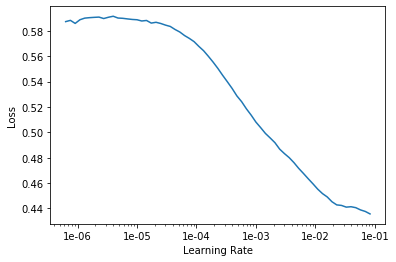

In [42]:
learner.lr_find()
learner.recorder.plot(skip_end=25)

In [97]:
l = fit_model(src, model, epochs=2, lr=1e-3, size=INPUT_SHAPE, bs=32, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MAge,MBackg,MBeard,MBlink,MContr,MDarkG,MDetec,MEmSad,MEmFea,MEmCon,MEmNeu,MEmSur,MEmDis,MEmAng,MEmHap,MEtAsi,MEtBla,MEtHis,MEtInd,MEtWhi,MExpre,MFaceD,MGende,MGlsCo,MGlsRe,MGrays,MHatCo,MLooki,MMouth,MMusta,MNoise,MPixel,MQuali,MRedEy,MSatur,MSharp,MSkinR,MUnnat,MWashe,time


KeyboardInterrupt: 

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MAge,MBackg,MBeard,MBlink,MContr,MDarkG,MDetec,MEmSad,MEmFea,MEmCon,MEmNeu,MEmSur,MEmDis,MEmAng,MEmHap,MEtAsi,MEtBla,MEtHis,MEtInd,MEtWhi,MExpre,MFaceD,MGende,MGlsCo,MGlsRe,MGrays,MHatCo,MLooki,MMouth,MMusta,MNoise,MPixel,MQuali,MRedEy,MSatur,MSharp,MSkinR,MUnnat,MWashe,time
0,0.103346,0.100981,0.004722,0.003835,0.031679,0.029014,0.031729,0.612184,0.390101,0.727451,0.581676,0.156256,0.483472,0.702042,0.157069,0.292376,0.288932,0.152116,0.300664,0.211367,0.306753,0.657476,0.235746,0.439401,0.405877,0.249695,0.605442,0.430717,0.511973,0.911038,0.286142,0.442550,0.105630,0.327315,0.145373,0.459293,0.685246,0.216717,0.214066,0.701303,0.184664,0.310109,0.785802,0.277546,0.552090,0.138917,06:15
1,0.094210,0.091910,0.003649,0.002531,0.031131,0.027158,0.027441,0.629200,0.413115,0.744409,0.581676,0.169101,0.507280,0.710255,0.156357,0.292376,0.288932,0.191321,0.300572,0.215236,0.307134,0.693386,0.226432,0.459314,0.380588,0.247609,0.620169,0.471096,0.557971,0.918590,0.302862,0.448121,0.108492,0.356746,0.150684,0.485645,0.709895,0.250697,0.205489,0.719819,0.184664,0.301407,0.795880,0.378910,0.602352,0.138384,06:17


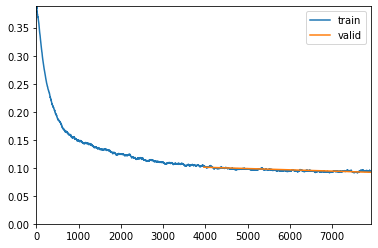

In [44]:
l = fit_model(src, model, epochs=2, lr=1e-3, size=INPUT_SHAPE, bs=32, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MAge,MBackg,MBeard,MBlink,MContr,MDarkG,MDetec,MEmSad,MEmFea,MEmCon,MEmNeu,MEmSur,MEmDis,MEmAng,MEmHap,MEtAsi,MEtBla,MEtHis,MEtInd,MEtWhi,MExpre,MFaceD,MGende,MGlsCo,MGlsRe,MGrays,MHatCo,MLooki,MMouth,MMusta,MNoise,MPixel,MQuali,MRedEy,MSatur,MSharp,MSkinR,MUnnat,MWashe,time
0,0.061863,0.059589,0.002275,0.002630,0.026830,0.021278,0.006575,0.348403,0.545052,0.784438,0.598396,0.193131,0.435132,0.740890,0.304604,0.306679,0.336571,0.489485,0.329785,0.283003,0.365833,0.777763,0.217139,0.484542,0.348344,0.246594,0.643265,0.735204,0.629261,0.924493,0.415320,0.617411,0.115156,0.473790,0.391357,0.735887,0.733611,0.231206,0.192776,0.769704,0.178821,0.298273,0.821552,0.719256,0.696381,0.141990,06:07
1,0.048423,0.047664,0.001156,0.001042,0.024629,0.016649,0.004188,0.490735,0.575155,0.851872,0.598396,0.223001,0.615115,0.755895,0.452233,0.305401,0.353456,0.571977,0.381372,0.397138,0.366797,0.812969,0.245056,0.440611,0.475451,0.266636,0.728572,0.778750,0.661042,0.945015,0.517199,0.638760,0.124969,0.543976,0.571446,0.767762,0.817193,0.267594,0.204020,0.790778,0.178821,0.318595,0.847515,0.765773,0.821294,0.154741,06:07


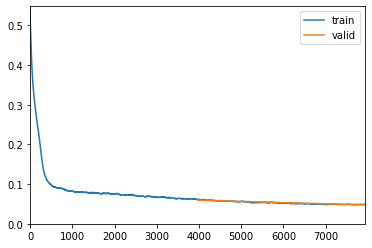

In [52]:
l = fit_model(src, model, epochs=2, lr=1e-3, size=INPUT_SHAPE, bs=32, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MAge,MBackg,MBeard,MBlink,MContr,MDarkG,MDetec,MEmSad,MEmFea,MEmCon,MEmNeu,MEmSur,MEmDis,MEmAng,MEmHap,MEtAsi,MEtBla,MEtHis,MEtInd,MEtWhi,MExpre,MFaceD,MGende,MGlsCo,MGlsRe,MGrays,MHatCo,MLooki,MMouth,MMusta,MNoise,MPixel,MQuali,MRedEy,MSatur,MSharp,MSkinR,MUnnat,MWashe,time
0,0.060723,0.057833,0.002207,0.002360,0.026070,0.020769,0.006427,0.340743,0.525145,0.810618,0.598396,0.216668,0.561491,0.748942,0.325249,0.285489,0.320813,0.539500,0.386790,0.284672,0.323163,0.777471,0.237581,0.530850,0.424612,0.252966,0.598550,0.747321,0.652396,0.927530,0.486682,0.588901,0.115970,0.473492,0.405665,0.711530,0.764496,0.216786,0.196709,0.752672,0.178821,0.293290,0.815718,0.735191,0.767773,0.144618,06:03
1,0.047933,0.046501,0.001169,0.001059,0.023532,0.016561,0.004180,0.471614,0.576875,0.851518,0.598396,0.225031,0.634022,0.766832,0.425924,0.309009,0.351783,0.603406,0.377752,0.396223,0.367232,0.814736,0.248707,0.452728,0.469570,0.267027,0.729563,0.783239,0.676880,0.946719,0.542670,0.650383,0.128365,0.547827,0.542297,0.775563,0.817455,0.269513,0.203908,0.798002,0.180084,0.310619,0.837586,0.772886,0.831654,0.165498,06:06


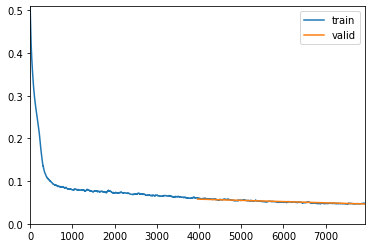

In [41]:
l = fit_model(src, model, epochs=2, lr=1e-3, size=INPUT_SHAPE, bs=32, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MAge,MBackg,MBeard,MBlink,MContr,MDarkG,MDetec,MEmSad,MEmFea,MEmCon,MEmNeu,MEmSur,MEmDis,MEmAng,MEmHap,MEtAsi,MEtBla,MEtHis,MEtInd,MEtWhi,MExpre,MFaceD,MGende,MGlsCo,MGlsRe,MGrays,MHatCo,MLooki,MMouth,MMusta,MNoise,MPixel,MQuali,MRedEy,MSatur,MSharp,MSkinR,MUnnat,MWashe,time
0,0.057568,0.059722,0.001999,0.002439,0.025595,0.020642,0.009046,0.488182,0.521214,0.806657,0.767017,0.140904,0.538719,0.650478,0.319132,0.288846,0.377104,0.473639,0.257033,0.322280,0.317246,0.741444,0.257317,0.475816,0.438930,0.271667,0.652158,0.748942,0.559900,0.955995,0.419695,0.610640,0.053665,0.433164,0.270235,0.721879,0.752809,0.060432,0.222327,0.646920,0.160526,0.276961,0.343854,0.727506,0.695162,0.130453,06:18
1,0.044261,0.043675,0.000704,0.000763,0.023062,0.016762,0.002383,0.519089,0.586515,0.846043,0.767017,0.150238,0.602877,0.683643,0.341623,0.302660,0.407004,0.549448,0.300396,0.385098,0.338877,0.801069,0.270880,0.494015,0.582305,0.344058,0.728763,0.803169,0.580583,0.965136,0.480424,0.605350,0.058080,0.519313,0.320371,0.776051,0.817554,0.060432,0.225120,0.700268,0.160526,0.288097,0.470432,0.780004,0.840711,0.130770,06:19


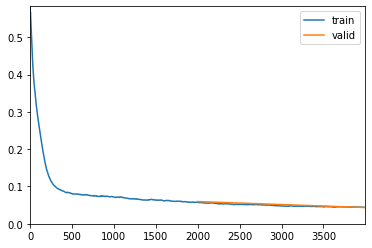

In [65]:
l = fit_model(src, model, epochs=2, lr=1e-3, size=INPUT_SHAPE, bs=32, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MAge,MBackg,MBeard,MBlink,MContr,MDarkG,MDetec,MEmSad,MEmFea,MEmCon,MEmNeu,MEmSur,MEmDis,MEmAng,MEmHap,MEtAsi,MEtBla,MEtHis,MEtInd,MEtWhi,MExpre,MFaceD,MGende,MGlsCo,MGlsRe,MGrays,MHatCo,MLooki,MMouth,MMusta,MNoise,MPixel,MQuali,MRedEy,MSatur,MSharp,MSkinR,MUnnat,MWashe,time
0,0.075169,0.055608,0.001726,0.001812,0.024599,0.018281,0.009191,0.468853,0.524773,0.839074,0.598396,0.183486,0.597930,0.746748,0.403156,0.299466,0.351062,0.596633,0.386523,0.412996,0.381567,0.804812,0.251842,0.477531,0.468402,0.268104,0.714296,0.774291,0.625704,0.942313,0.513370,0.649260,0.116647,0.524388,0.573927,0.757443,0.807163,0.284035,0.199754,0.782192,0.178821,0.310496,0.836932,0.704692,0.710895,0.161619,06:08
1,0.065917,0.052125,0.001671,0.001782,0.024909,0.017607,0.006155,0.480316,0.543761,0.846879,0.598396,0.187614,0.607765,0.751759,0.434177,0.297078,0.369565,0.574805,0.380969,0.414846,0.362160,0.811858,0.255808,0.475843,0.470260,0.278059,0.711954,0.774270,0.629284,0.943422,0.532115,0.659254,0.111250,0.511964,0.572883,0.762273,0.806963,0.274762,0.196121,0.779313,0.178821,0.326062,0.838992,0.627683,0.791809,0.157495,06:09
2,0.062296,0.051641,0.001744,0.001924,0.024869,0.017485,0.005619,0.513189,0.558371,0.848420,0.598396,0.178563,0.585936,0.758188,0.418825,0.307933,0.362999,0.571412,0.386578,0.430675,0.361053,0.806843,0.247379,0.454685,0.528982,0.268523,0.714326,0.771256,0.613604,0.939775,0.502672,0.676503,0.115108,0.511182,0.591487,0.762497,0.804799,0.271948,0.197109,0.787027,0.178768,0.333814,0.843250,0.668606,0.758879,0.159708,06:09
3,0.058662,0.051145,0.001845,0.002015,0.024610,0.017234,0.005441,0.500885,0.554243,0.846276,0.598396,0.179817,0.609379,0.752199,0.431159,0.308357,0.360581,0.626481,0.408274,0.398930,0.357856,0.817438,0.260436,0.443120,0.443440,0.282735,0.720283,0.781343,0.639075,0.948137,0.543690,0.685453,0.112145,0.511457,0.578598,0.766687,0.808252,0.268800,0.199421,0.789460,0.179228,0.329141,0.841548,0.525819,0.782498,0.154761,06:08
4,0.056545,0.049844,0.001555,0.001612,0.024516,0.016874,0.005287,0.528981,0.558571,0.849887,0.598396,0.185258,0.626571,0.750023,0.456923,0.334940,0.362352,0.553330,0.391348,0.425693,0.369118,0.814746,0.248023,0.455130,0.448990,0.283936,0.717540,0.784692,0.650370,0.948249,0.543270,0.675220,0.114902,0.526335,0.567984,0.766812,0.803828,0.258411,0.199144,0.790805,0.180991,0.331802,0.842491,0.654281,0.765589,0.151996,06:09
5,0.055522,0.049310,0.001563,0.001612,0.024451,0.016418,0.005267,0.492174,0.557780,0.847973,0.598396,0.187716,0.624930,0.766246,0.450751,0.319984,0.386536,0.568768,0.381474,0.431470,0.383649,0.812441,0.254584,0.445718,0.470357,0.279739,0.732565,0.790399,0.661506,0.946621,0.526622,0.692187,0.118761,0.530121,0.582935,0.772034,0.815782,0.264628,0.196834,0.791742,0.183597,0.334592,0.846367,0.699304,0.726756,0.158888,06:09
6,0.055055,0.049158,0.001635,0.001788,0.024284,0.016275,0.005175,0.512796,0.567794,0.850750,0.598396,0.187676,0.642834,0.759446,0.432128,0.323904,0.362319,0.618346,0.402307,0.432867,0.358800,0.819153,0.248177,0.432797,0.482256,0.274244,0.729677,0.794845,0.634520,0.947918,0.565819,0.682092,0.117723,0.525095,0.566467,0.763706,0.813918,0.261201,0.207092,0.794977,0.189635,0.333547,0.848879,0.677586,0.800794,0.164732,06:09
7,0.052785,0.048320,0.001485,0.001503,0.024279,0.015970,0.005083,0.513221,0.568315,0.851180,0.598396,0.190326,0.646587,0.757781,0.471202,0.312838,0.386390,0.609084,0.381643,0.455377,0.380255,0.817700,0.250401,0.449922,0.487805,0.287242,0.733668,0.786278,0.658793,0.945538,0.561223,0.677951,0.119371,0.529982,0.565870,0.770601,0.818074,0.308009,0.197986,0.795091,0.194738,0.329813,0.845666,0.682497,0.802308,0.162133,06:09
8,0.051819,0.047724,0.001462,0.001468,0.023964,0.015817,0.005012,0.530705,0.568059,0.851055,0.598396,0.193784,0.643087,0.764662,0.459170,0.317713,0.376114,0.616206,0.389425,0.461737,0.400544,0.821608,0.258824,0.445043,0.485334,0.287625,0.734124,0.796756,0.648270,0.946630,0.532483

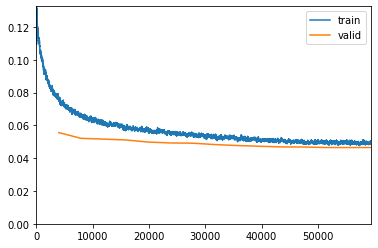

In [53]:
l = fit_model(src, model, epochs=15, lr=1e-4, size=INPUT_SHAPE, bs=32, transforms=custom_transforms, frozen_layers=[4], loss_weights=[1,1,1,1,1], eps=1e-1)

In [ ]:
l = fit_model(src, model, epochs=15, lr=1e-4, size=INPUT_SHAPE, bs=32, transforms=simple_transforms, frozen_layers=[], loss_weights=[.2,.2,1,1,.2], eps=1e-1)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MAge,MBackg,MBeard,MBlink,MContr,MDarkG,MDetec,MEmSad,MEmFea,MEmCon,MEmNeu,MEmSur,MEmDis,MEmAng,MEmHap,MEtAsi,MEtBla,MEtHis,MEtInd,MEtWhi,MExpre,MFaceD,MGende,MGlsCo,MGlsRe,MGrays,MHatCo,MLooki,MMouth,MMusta,MNoise,MPixel,MQuali,MRedEy,MSatur,MSharp,MSkinR,MUnnat,MWashe,time


In [ ]:
l = fit_model(src, model, epochs=15, lr=1e-4, size=INPUT_SHAPE, bs=32, transforms=simple_transforms, frozen_layers=[], loss_weights=[.2,.2,1,1,.2], eps=1e-1)

In [ ]:
l = fit_model(src, model, epochs=15, lr=1e-4, size=INPUT_SHAPE, bs=32, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

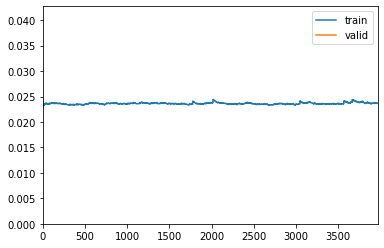

In [57]:
l = fit_model(src, model, epochs=1, lr=1e-8, size=INPUT_SHAPE, bs=32, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MAge,MBackg,MBeard,MBlink,MContr,MDarkG,MDetec,MEmSad,MEmFea,MEmCon,MEmNeu,MEmSur,MEmDis,MEmAng,MEmHap,MEtAsi,MEtBla,MEtHis,MEtInd,MEtWhi,MExpre,MFaceD,MGende,MGlsCo,MGlsRe,MGrays,MHatCo,MLooki,MMouth,MMusta,MNoise,MPixel,MQuali,MRedEy,MSatur,MSharp,MSkinR,MUnnat,MWashe,time
0,0.021688,0.037213,0.000498,0.000514,0.020364,0.013608,0.002229,0.753623,0.757645,0.932223,0.800712,0.503150,0.804014,0.784049,0.543508,0.507190,0.556218,0.717517,0.501909,0.577047,0.524020,0.905951,0.521310,0.604708,0.687324,0.525781,0.882425,0.914675,0.648271,0.982748,0.705882,0.698321,0.500550,0.776646,0.597162,0.898870,0.908547,0.500202,0.500592,0.803076,0.498767,0.514005,0.564427,0.853569,0.925834,0.503441,06:18


MAge tensor([5906.,  230.,  280.,  780.])
MBackg tensor([3586.,  627.,  744., 2143.])
MBeard tensor([3191.,  264.,  200., 3445.])
MBlink tensor([6424.,  224.,  224.,  900.])
MContr tensor([3314., 3261., 3284., 6937.])
MDarkG tensor([4061.,  540.,  456., 2043.])
MDetec tensor([1160.,  246.,  393., 5301.])
MEmSad tensor([6419.,  605.,  717.,  787.])
MEmFea tensor([6710., 1035., 1124., 1111.])
MEmCon tensor([6531.,  506.,  611.,  700.])
MEmNeu tensor([5977.,  253.,  284.,  682.])
MEmSur tensor([6715., 1449., 1552., 1512.])
MEmDis tensor([6287.,  439.,  615.,  719.])
MEmAng tensor([6635.,  815.,  909.,  949.])
MEmHap tensor([3837.,  268.,  293., 2702.])
MEtAsi tensor([6808., 2072., 2095., 2269.])
MEtBla tensor([6642.,  639.,  654.,  989.])
MEtHis tensor([6223.,  247.,  308.,  610.])
MEtInd tensor([6762., 1479., 1510., 1657.])
MEtWhi tensor([2882.,  356.,  412., 3450.])
MExpre tensor([3831.,  258.,  256., 2755.])
MFaceD tensor([ 928.,  499.,  508., 6509.])
MGende tensor([3916.,   60.,   48.

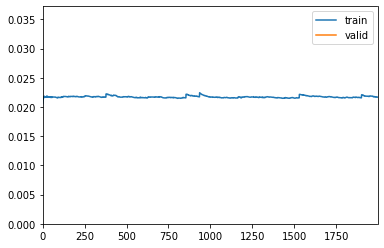

In [85]:
l = fit_model(src, model, epochs=1, lr=1e-8, size=INPUT_SHAPE, bs=32, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

In [88]:
show_results(learner, DatasetType.Valid, rows=3)

FileNotFoundError: [Errno 2] No such file or directory: '../models/../data/face/unlabeled_cropped_images/00096395.jpg'

In [87]:
save_torch_inference(learner.model, '../models/model_v2_all.pth')

In [54]:
a = 'train_loss	valid_loss	Ldist		Lspatial	Lbin_BCE	Lbin_MSE	Lfloat		MAge		MBackg		MBeard		MBlink		MContr		MDarkG		MDetec		MEmSad		MEmFea		MEmCon		MEmNeu		MEmSur		MEmDis		MEmAng		MEmHap		MEtAsi		MEtBla		MEtHis		MEtInd		MEtWhi		MExpre		MFaceD		MGende		MGlsCo		MGlsRe		MGrays		MHatCo		MLooki		MMouth		MMusta		MNoise		MPixel		MQuali		MRedEy		MSatur		MSharp		MSkinR		MUnnat		MWashe'
b = '0.024115	0.037841	0.000595	0.000637	0.020611	0.013411	0.002587	0.686242	0.748333	0.933018	0.959437	0.995641	0.799429	0.945030	0.527823	0.316506	0.470277	0.731865	0.390801	0.547448	0.442925	0.910816	0.565954	0.755403	0.681515	0.491935	0.893564	0.906542	0.992721	0.982916	0.666771	0.979346	0.997016	0.749295	0.971463	0.912189	0.933047	0.995393	0.991357	0.964213	0.991370	0.991434	0.985316	0.824265	0.969596	0.996538'

In [61]:
a = 'train_loss	valid_loss	Ldist		Lspatial	Lbin_BCE	Lbin_MSE	Lfloat		MAge		MBackg		MBeard		MBlink		MContr		MDarkG		MDetec		MEmSad		MEmFea		MEmCon		MEmNeu		MEmSur		MEmDis		MEmAng		MEmHap		MEtAsi		MEtBla		MEtHis		MEtInd		MEtWhi		MExpre		MFaceD		MGende		MGlsCo		MGlsRe		MGrays		MHatCo		MLooki		MMouth		MMusta		MNoise		MPixel		MQuali		MRedEy		MSatur		MSharp		MSkinR		MUnnat		MWashe'
b = '0.024115	0.037841	0.000595	0.000637	0.020611	0.013411	0.002587	0.686242	0.748333	0.933018	0.959437	0.995641	0.799429	0.945030	0.527823	0.316506	0.470277	0.731865	0.390801	0.547448	0.442925	0.910816	0.565954	0.755403	0.681515	0.491935	0.893564	0.906542	0.992721	0.982916	0.666771	0.979346	0.997016	0.749295	0.971463	0.912189	0.933047	0.995393	0.991357	0.964213	0.991370	0.991434	0.985316	0.824265	0.969596	0.996538'
a = [x for x in a.split('\t') if x != ''][7:]
b = [x for x in b.split('\t') if x != ''][7:]
print('\t'.join(b))

0.686242	0.748333	0.933018	0.959437	0.995641	0.799429	0.945030	0.527823	0.316506	0.470277	0.731865	0.390801	0.547448	0.442925	0.910816	0.565954	0.755403	0.681515	0.491935	0.893564	0.906542	0.992721	0.982916	0.666771	0.979346	0.997016	0.749295	0.971463	0.912189	0.933047	0.995393	0.991357	0.964213	0.991370	0.991434	0.985316	0.824265	0.969596	0.996538


Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MAge,MBack,MBear,MBlin,MCont,MDark,MEmot,MEmot,MEthn,MEthn,MEthn,MEthn,MEthn,MExpr,MFace,MGend,MGlas,MHatC,MLook,MMout,MMust,MShar,MSkin,MUnna,time
0,0.105542,0.061528,0.003084,0.003210,0.028821,0.016125,0.010287,0.065057,0.153539,0.101672,0.121110,0.076239,0.068464,0.272443,0.272443,0.531690,0.531690,0.531690,0.531690,0.531690,0.090615,0.061421,0.035195,0.083639,0.097850,0.101589,0.088358,0.093821,0.091799,0.071914,0.045887,05:09
1,0.083581,0.055622,0.002476,0.002652,0.028273,0.016318,0.005904,0.061844,0.150125,0.095176,0.124798,0.091210,0.065709,0.277278,0.277278,0.553084,0.553084,0.553084,0.553084,0.553084,0.094656,0.057304,0.035203,0.080396,0.097781,0.106470,0.088047,0.092613,0.096679,0.075383,0.058384,05:09
2,0.077125,0.053621,0.002177,0.002554,0.028129,0.015640,0.005121,0.058917,0.140214,0.093065,0.118028,0.084634,0.066820,0.266277,0.266277,0.554679,0.554679,0.554679,0.554679,0.554679,0.088976,0.053910,0.033474,0.084718,0.098125,0.108489,0.087868,0.090079,0.081355,0.073548,0.048069,05:09
3,0.072406,0.053209,0.002087,0.002406,0.028355,0.015287,0.005074,0.058343,0.147404,0.093461,0.105430,0.081084,0.066026,0.266701,0.266701,0.539135,0.539135,0.539135,0.539135,0.539135,0.088417,0.055189,0.033881,0.072245,0.096856,0.097572,0.088655,0.088440,0.094032,0.075846,0.051285,05:09
4,0.069014,0.051453,0.001966,0.002069,0.027800,0.015076,0.004543,0.057422,0.139088,0.090985,0.130588,0.075381,0.064451,0.254565,0.254565,0.526434,0.526434,0.526434,0.526434,0.526434,0.087785,0.050660,0.033627,0.086276,0.095440,0.100042,0.086481,0.089518,0.081807,0.072359,0.054636,05:09
5,0.065702,0.050795,0.001715,0.001946,0.027918,0.014652,0.004564,0.056142,0.138998,0.091203,0.116678,0.076166,0.064730,0.261582,0.261582,0.521460,0.521460,0.521460,0.521460,0.521460,0.087779,0.053469,0.032455,0.075910,0.097783,0.097974,0.085684,0.087797,0.080393,0.066235,0.051625,05:09
6,0.064806,0.050045,0.001599,0.001740,0.027844,0.014351,0.004510,0.056024,0.135568,0.089901,0.114624,0.077716,0.063667,0.259430,0.259430,0.514012,0.514012,0.514012,0.514012,0.514012,0.086227,0.053495,0.032193,0.075245,0.095099,0.100903,0.085641,0.086987,0.071394,0.063201,0.056139,05:09
7,0.062936,0.049507,0.001596,0.001735,0.027534,0.014422,0.004220,0.055421,0.135531,0.088238,0.121590,0.079345,0.064532,0.254669,0.254669,0.511592,0.511592,0.511592,0.511592,0.511592,0.085120,0.050010,0.032041,0.080487,0.095814,0.097848,0.085364,0.087122,0.074483,0.064273,0.059300,05:10
8,0.062264,0.048972,0.001480,0.001570,0.027471,0.014305,0.004146,0.055439,0.136053,0.090157,0.112625,0.076274,0.064847,0.252652,0.252652,0.510685,0.510685,0.510685,0.510685,0.510685,0.085121,0.051586,0.030977,0.075749,0.095325,0.100146,0.085932,0.086221,0.080419,0.066210,0.058354,05:09
9,0.061449,0.048939,0.001477,0.001582,0.027519,0.014234,0.004127,0.055331,0.134883,0.089148,0.113527,0.072679,0.064884,0.250186,0.250186,0.508981,0.508981,0.508981,0.508981,0.508981,0.085239,0.051406,0.031717,0.079820,0.095253,0.099236,0.087777,0.086310,0.074473,0.063417,0.059147,05:09


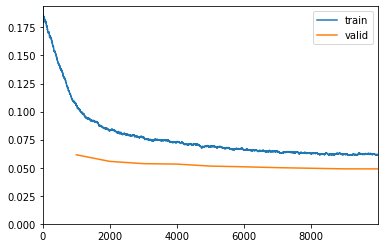

In [81]:
l = fit_model(src, model, epochs=10, lr=1e-4, size=INPUT_SHAPE, bs=32, transforms=custom_transforms, frozen_layers=[4], loss_weights=[1,1,1,1,1], eps=1e-1)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MAge,MBack,MBear,MBlin,MCont,MDark,MEmot,MEmot,MEthn,MEthn,MEthn,MEthn,MEthn,MExpr,MFace,MGend,MGlas,MHatC,MLook,MMout,MMust,MShar,MSkin,MUnna,time
0,0.046042,0.042959,0.000294,0.000314,0.027381,0.014156,0.000815,0.054709,0.136611,0.088705,0.110058,0.073724,0.064352,0.247334,0.247334,0.516769,0.516769,0.516769,0.516769,0.516769,0.084202,0.049082,0.029672,0.075524,0.095192,0.099244,0.084912,0.085131,0.076771,0.066499,0.057273,05:09
1,0.046201,0.043116,0.000312,0.000351,0.027227,0.014397,0.000828,0.053482,0.136113,0.089309,0.105517,0.079815,0.063579,0.250481,0.250481,0.506422,0.506422,0.506422,0.506422,0.506422,0.087090,0.051584,0.027229,0.077576,0.098462,0.100019,0.085870,0.082835,0.084636,0.074380,0.059950,05:09
2,0.046530,0.042808,0.000325,0.000342,0.026878,0.014453,0.000809,0.052932,0.140463,0.090406,0.103734,0.077789,0.066075,0.244385,0.244385,0.502375,0.502375,0.502375,0.502375,0.502375,0.083826,0.057277,0.027146,0.075180,0.095354,0.108523,0.083415,0.085050,0.085158,0.090685,0.052597,05:09
3,0.045373,0.042418,0.000328,0.000334,0.027216,0.013706,0.000835,0.051499,0.134447,0.087290,0.098447,0.077420,0.063479,0.238208,0.238208,0.524623,0.524623,0.524623,0.524623,0.524623,0.080994,0.058870,0.026096,0.076921,0.094685,0.095019,0.084198,0.082366,0.065870,0.077814,0.051606,05:10
4,0.044727,0.042293,0.000338,0.000383,0.026559,0.014202,0.000811,0.050490,0.136796,0.090443,0.132086,0.070571,0.064625,0.237192,0.237192,0.518248,0.518248,0.518248,0.518248,0.518248,0.088206,0.050638,0.024922,0.079452,0.093576,0.093648,0.082172,0.082825,0.076987,0.074020,0.060239,05:10
5,0.044013,0.041662,0.000305,0.000329,0.026553,0.013674,0.000801,0.050454,0.134592,0.085548,0.116870,0.077065,0.067894,0.233083,0.233083,0.475330,0.475330,0.475330,0.475330,0.475330,0.084963,0.047025,0.028860,0.082630,0.093363,0.100864,0.080448,0.082109,0.082122,0.056678,0.063977,05:10
6,0.043140,0.041461,0.000304,0.000322,0.026411,0.013614,0.000810,0.048535,0.133870,0.089513,0.112268,0.072445,0.064563,0.223884,0.223884,0.530102,0.530102,0.530102,0.530102,0.530102,0.083098,0.048728,0.023977,0.082188,0.096316,0.096506,0.083955,0.081899,0.069690,0.063399,0.058743,05:09
7,0.042476,0.040935,0.000299,0.000318,0.026258,0.013263,0.000796,0.048038,0.132105,0.086288,0.115133,0.075327,0.067146,0.216985,0.216985,0.483068,0.483068,0.483068,0.483068,0.483068,0.080853,0.050214,0.023508,0.080935,0.091748,0.095101,0.082688,0.079701,0.071238,0.073624,0.062518,05:09
8,0.041886,0.040814,0.000296,0.000315,0.026271,0.013141,0.000791,0.047885,0.132402,0.085082,0.112421,0.073643,0.065705,0.216770,0.216770,0.486766,0.486766,0.486766,0.486766,0.486766,0.080454,0.048953,0.023238,0.076279,0.092855,0.097011,0.080712,0.079258,0.075023,0.067994,0.061374,05:09
9,0.041720,0.040833,0.000293,0.000312,0.026421,0.013018,0.000789,0.048011,0.131953,0.085073,0.105457,0.071553,0.064876,0.218660,0.218660,0.483071,0.483071,0.483071,0.483071,0.483071,0.083406,0.049817,0.023509,0.076378,0.092360,0.095254,0.080721,0.079465,0.075680,0.067445,0.058301,05:09


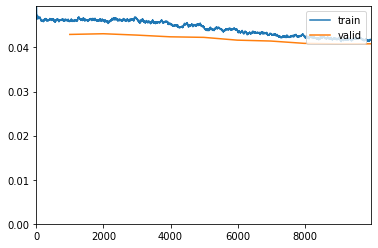

In [82]:
l = fit_model(src, model, epochs=10, lr=1e-4, size=INPUT_SHAPE, bs=32, transforms=simple_transforms, frozen_layers=[], loss_weights=[.2,.2,1,1,.2], eps=1e-1)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MAge,MBack,MBear,MBlin,MCont,MDark,MEmot,MEmot,MEthn,MEthn,MEthn,MEthn,MEthn,MExpr,MFace,MGend,MGlas,MHatC,MLook,MMout,MMust,MShar,MSkin,MUnna,time
0,0.060500,0.046935,0.001530,0.001641,0.026482,0.013120,0.004161,0.048219,0.133375,0.084425,0.104134,0.070544,0.064633,0.216090,0.216090,0.489242,0.489242,0.489242,0.489242,0.489242,0.080699,0.050187,0.024616,0.076981,0.092918,0.096174,0.081891,0.080536,0.076014,0.067975,0.058337,05:09
1,0.059724,0.046806,0.001513,0.001592,0.026619,0.012947,0.004134,0.048534,0.131810,0.085182,0.105611,0.071499,0.065200,0.220701,0.220701,0.475945,0.475945,0.475945,0.475945,0.475945,0.080968,0.047494,0.024345,0.076189,0.092647,0.095110,0.081919,0.080491,0.077059,0.062263,0.056625,05:09
2,0.059336,0.046857,0.001486,0.001562,0.026535,0.013126,0.004147,0.048480,0.131837,0.085632,0.114303,0.071787,0.064596,0.222700,0.222700,0.476485,0.476485,0.476485,0.476485,0.476485,0.080878,0.046143,0.025435,0.078684,0.093386,0.097563,0.082126,0.080104,0.074861,0.059029,0.061931,05:09
3,0.059045,0.047033,0.001518,0.001612,0.026655,0.013065,0.004184,0.049047,0.132176,0.086145,0.112879,0.068688,0.064452,0.222660,0.222660,0.478687,0.478687,0.478687,0.478687,0.478687,0.080869,0.047476,0.025400,0.075260,0.092206,0.095434,0.083963,0.080724,0.075420,0.058300,0.059579,05:09
4,0.058644,0.047266,0.001540,0.001677,0.027010,0.012816,0.004223,0.048652,0.131648,0.084416,0.103249,0.067805,0.062588,0.226542,0.226542,0.473648,0.473648,0.473648,0.473648,0.473648,0.080358,0.047629,0.025561,0.070299,0.092620,0.096794,0.082099,0.080644,0.071934,0.064010,0.056932,05:09
5,0.058823,0.047098,0.001519,0.001597,0.026818,0.012996,0.004168,0.048814,0.131684,0.086273,0.109914,0.067977,0.061561,0.221996,0.221996,0.475093,0.475093,0.475093,0.475093,0.475093,0.080540,0.048584,0.025507,0.076531,0.094917,0.097073,0.082462,0.081716,0.069330,0.067172,0.054706,05:09
6,0.059108,0.047524,0.001601,0.001728,0.026538,0.013452,0.004205,0.049021,0.134314,0.087336,0.119041,0.070751,0.065605,0.224530,0.224530,0.482169,0.482169,0.482169,0.482169,0.482169,0.083247,0.047820,0.025860,0.079521,0.094474,0.097921,0.080710,0.080881,0.078790,0.067597,0.056147,05:09
7,0.059345,0.047462,0.001575,0.001622,0.026791,0.013340,0.004133,0.049246,0.133045,0.086667,0.114373,0.068732,0.066334,0.224949,0.224949,0.490178,0.490178,0.490178,0.490178,0.490178,0.080486,0.045035,0.026474,0.076270,0.093521,0.099281,0.083683,0.080673,0.070699,0.057699,0.067112,05:09
8,0.058868,0.047586,0.001510,0.001562,0.026701,0.013426,0.004386,0.049571,0.132949,0.085912,0.112615,0.079399,0.066102,0.231618,0.231618,0.474964,0.474964,0.474964,0.474964,0.474964,0.084750,0.051763,0.028293,0.076035,0.092639,0.094910,0.081309,0.081365,0.080150,0.072091,0.056740,05:09
9,0.058308,0.047904,0.001499,0.001658,0.026982,0.013392,0.004372,0.049282,0.132486,0.086676,0.105012,0.067390,0.062903,0.231433,0.231433,0.522383,0.522383,0.522383,0.522383,0.522383,0.081510,0.051079,0.026672,0.073865,0.091801,0.099814,0.082517,0.081615,0.070565,0.059949,0.057318,05:09


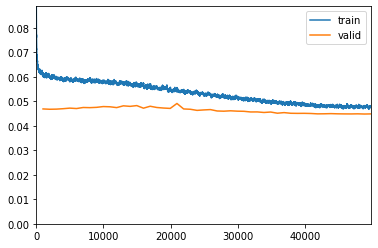

In [83]:
l = fit_model(src, model, epochs=50, lr=1e-4, size=INPUT_SHAPE, bs=32, transforms=custom_transforms, frozen_layers=[4], loss_weights=[1,1,1,1,1], eps=1e-1)

In [85]:
save_torch_inference(learner.model, '../models/model_v2.pth')

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MAge,MBack,MBear,MBlin,MCont,MDark,MDete,MEmot,MEmot,MEmot,MEmot,MEmot,MEmot,MEmot,MEmot,MEthn,MEthn,MEthn,MEthn,MEthn,MExpr,MFace,MGend,MGlas,MGlas,MGray,MLook,MMout,MMust,MNois,MPixe,MQual,MRedE,MSatu,MShar,MSkin,MUnna,MWash,time
0,0.056371,0.047806,0.000571,0.000593,0.024969,0.020186,0.001487,0.065485,0.130236,0.096173,0.120755,0.077128,0.075376,0.091931,1.032879,1.032879,1.032879,1.032879,1.032879,1.032879,1.032879,1.032879,0.550582,0.550582,0.550582,0.550582,0.550582,0.094956,0.072268,0.118808,0.141319,0.141319,0.092527,0.120287,0.100109,0.107787,0.089610,0.030567,0.089631,0.045583,0.040132,0.090176,0.067554,0.054630,0.055337,01:40
1,0.053218,0.047251,0.000584,0.000590,0.024519,0.020038,0.001521,0.063198,0.117376,0.096900,0.123258,0.087134,0.071598,0.098138,1.011690,1.011690,1.011690,1.011690,1.011690,1.011690,1.011690,1.011690,0.583102,0.583102,0.583102,0.583102,0.583102,0.096868,0.069073,0.112200,0.140175,0.140175,0.095366,0.125762,0.097078,0.104778,0.095923,0.029661,0.087451,0.044865,0.038823,0.086243,0.085473,0.051809,0.054390,01:41
2,0.051323,0.046762,0.000629,0.000685,0.024671,0.019210,0.001568,0.060907,0.126805,0.099052,0.135596,0.074459,0.071402,0.089068,0.979946,0.979946,0.979946,0.979946,0.979946,0.979946,0.979946,0.979946,0.532963,0.532963,0.532963,0.532963,0.532963,0.097318,0.063727,0.105294,0.146269,0.146269,0.086646,0.119064,0.096545,0.110590,0.086176,0.032749,0.085582,0.043376,0.042057,0.080329,0.059426,0.067326,0.052652,01:41
3,0.049202,0.045648,0.000578,0.000606,0.023967,0.018878,0.001618,0.060227,0.124698,0.089296,0.130924,0.079634,0.072112,0.086313,0.975907,0.975907,0.975907,0.975907,0.975907,0.975907,0.975907,0.975907,0.547157,0.547157,0.547157,0.547157,0.547157,0.096958,0.064469,0.102418,0.130987,0.130987,0.089067,0.117354,0.098731,0.102582,0.085799,0.028258,0.085898,0.045544,0.040265,0.082880,0.072561,0.049888,0.054899,01:41
4,0.047785,0.044714,0.000696,0.000724,0.023511,0.018353,0.001430,0.056799,0.120250,0.091765,0.115883,0.085875,0.069830,0.096939,0.934094,0.934094,0.934094,0.934094,0.934094,0.934094,0.934094,0.934094,0.518880,0.518880,0.518880,0.518880,0.518880,0.100142,0.067513,0.101760,0.127284,0.127284,0.091288,0.117964,0.095115,0.100844,0.092093,0.029064,0.083274,0.043966,0.038942,0.078525,0.085708,0.056641,0.053477,01:41
5,0.046452,0.043479,0.000521,0.000554,0.023360,0.017628,0.001415,0.055759,0.115102,0.090916,0.141072,0.076760,0.072856,0.080913,0.875602,0.875602,0.875602,0.875602,0.875602,0.875602,0.875602,0.875602,0.503353,0.503353,0.503353,0.503353,0.503353,0.093735,0.061851,0.095972,0.131993,0.131993,0.082227,0.116897,0.095444,0.102474,0.086987,0.028346,0.082517,0.044665,0.038842,0.074209,0.067500,0.067490,0.053134,01:41
6,0.045402,0.042875,0.000542,0.000604,0.023188,0.017192,0.001349,0.054653,0.118982,0.089099,0.118895,0.076714,0.071006,0.088549,0.864579,0.864579,0.864579,0.864579,0.864579,0.864579,0.864579,0.864579,0.496454,0.496454,0.496454,0.496454,0.496454,0.092627,0.061414,0.095732,0.127843,0.127843,0.085422,0.118030,0.095013,0.097682,0.083967,0.028500,0.081431,0.045175,0.038278,0.086982,0.073111,0.053192,0.051429,01:41
7,0.044147,0.042416,0.000551,0.000568,0.023023,0.016937,0.001337,0.054110,0.115568,0.091590,0.121442,0.077472,0.070663,0.083858,0.872195,0.872195,0.872195,0.872195,0.872195,0.872195,0.872195,0.872195,0.498460,0.498460,0.498460,0.498460,0.498460,0.094068,0.061274,0.095510,0.126530,0.126530,0.085750,0.114178,0.093442,0.097206,0.086476,0.029051,0.081191,0.044188,0.039063,0.079202,0.072828,0.060666,0.052000,01:41
8,0.044326,0.042130,0.000513,0.000560,0.023073,0.016665,0.001321,0.053761,0.115520,0.089930,0.112206,0.075224,0.070490,0.089447,0.845681,0.845681,0.845681,0.845681,0.845681,0.845681,0.845681,0.845681,0.496070,0.496070,0.496070,0.496070,0.496070,0.092902,0.062280,0.095222,0.122464,0.122464,0.080120,0.112756,0.094758,0.097755,0.085148,0.028360,0.080815,0.045094,0.037009,0.076692,0.069641,0.05758

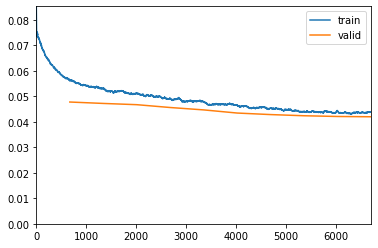

In [54]:
l = fit_model(src, model, epochs=10, lr=1e-4, size=size, bs=32, transforms=simple_transforms, frozen_layers=[], loss_weights=[.3,.3,1,1,.3], eps=1e-1)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MBack,MBlin,MCont,MDark,MDete,MExpr,MFace,MGlas,MGlas,MGray,MLook,MMout,MNois,MPixe,MQual,MRedE,MSatu,MShar,MSkin,MUnna,MWash,time
0,0.049436,0.039687,0.001189,0.002153,0.026720,0.007729,0.001896,0.071990,0.073190,0.060978,0.048283,0.070156,0.139446,0.043933,0.050138,0.050138,0.071359,0.078448,0.074629,0.068564,0.030739,0.075468,0.023638,0.005692,0.061566,0.051910,0.054996,0.053930,06:29
1,0.041369,0.033621,0.000344,0.000574,0.024734,0.007076,0.000893,0.076707,0.076983,0.059358,0.051939,0.077456,0.071322,0.049596,0.052021,0.052021,0.074161,0.082623,0.071970,0.069676,0.030096,0.079491,0.023687,0.004824,0.061674,0.055190,0.055287,0.055860,06:30
2,0.039649,0.033684,0.000121,0.000166,0.025379,0.007312,0.000707,0.080041,0.080041,0.056090,0.052786,0.073009,0.075900,0.032986,0.052045,0.052045,0.059211,0.086965,0.072380,0.073100,0.028287,0.085396,0.025266,0.005003,0.063388,0.058474,0.081409,0.053983,06:30
3,0.039225,0.032991,0.000120,0.000162,0.025019,0.007071,0.000620,0.081430,0.081101,0.045247,0.051225,0.075147,0.071785,0.042228,0.051960,0.051960,0.056625,0.082454,0.074694,0.065352,0.027533,0.083864,0.026252,0.004643,0.062708,0.050580,0.064803,0.050329,06:31
4,0.039040,0.033195,0.000116,0.000158,0.024369,0.007898,0.000654,0.080386,0.075866,0.058984,0.055867,0.075492,0.067080,0.048150,0.053150,0.053150,0.070792,0.081408,0.073295,0.089518,0.028228,0.096128,0.023951,0.005310,0.072901,0.053005,0.059045,0.057017,06:31
5,0.038402,0.032502,0.000112,0.000154,0.023940,0.007672,0.000623,0.077844,0.077859,0.076043,0.054213,0.070664,0.072092,0.044442,0.049623,0.049623,0.084445,0.080843,0.072864,0.070159,0.026470,0.074356,0.024167,0.005170,0.071696,0.080875,0.058679,0.061673,06:31
6,0.038147,0.032145,0.000097,0.000131,0.023815,0.007525,0.000578,0.077334,0.080844,0.066050,0.054402,0.072145,0.070600,0.049769,0.049817,0.049817,0.081691,0.083657,0.073284,0.072134,0.026815,0.080732,0.023376,0.004696,0.070013,0.065287,0.059629,0.061033,06:31
7,0.037723,0.031886,0.000115,0.000135,0.024108,0.006952,0.000576,0.076528,0.077297,0.058571,0.053075,0.074420,0.069180,0.046685,0.048037,0.048037,0.070103,0.083236,0.069389,0.067993,0.026510,0.079313,0.023645,0.004487,0.066243,0.058024,0.058815,0.055620,06:31
8,0.037518,0.031750,0.000103,0.000136,0.024004,0.006936,0.000571,0.080536,0.079982,0.060092,0.053049,0.075067,0.069739,0.048436,0.047462,0.047462,0.071002,0.082010,0.071150,0.066404,0.026472,0.075002,0.023087,0.004415,0.066169,0.059137,0.056209,0.055382,06:31


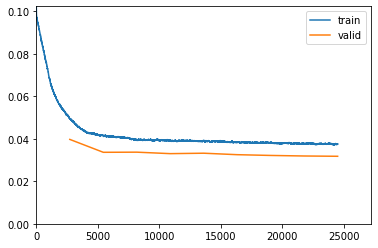

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [56]:
l = fit_model(src, model, epochs=10, lr=1e-4, size=size, bs=32, transforms=simple_transforms, frozen_layers=[], loss_weights=[.3,.3,1,1,.3], eps=1e-1)

In [58]:
save_torch_inference(learner.model, '../server/model.pth')

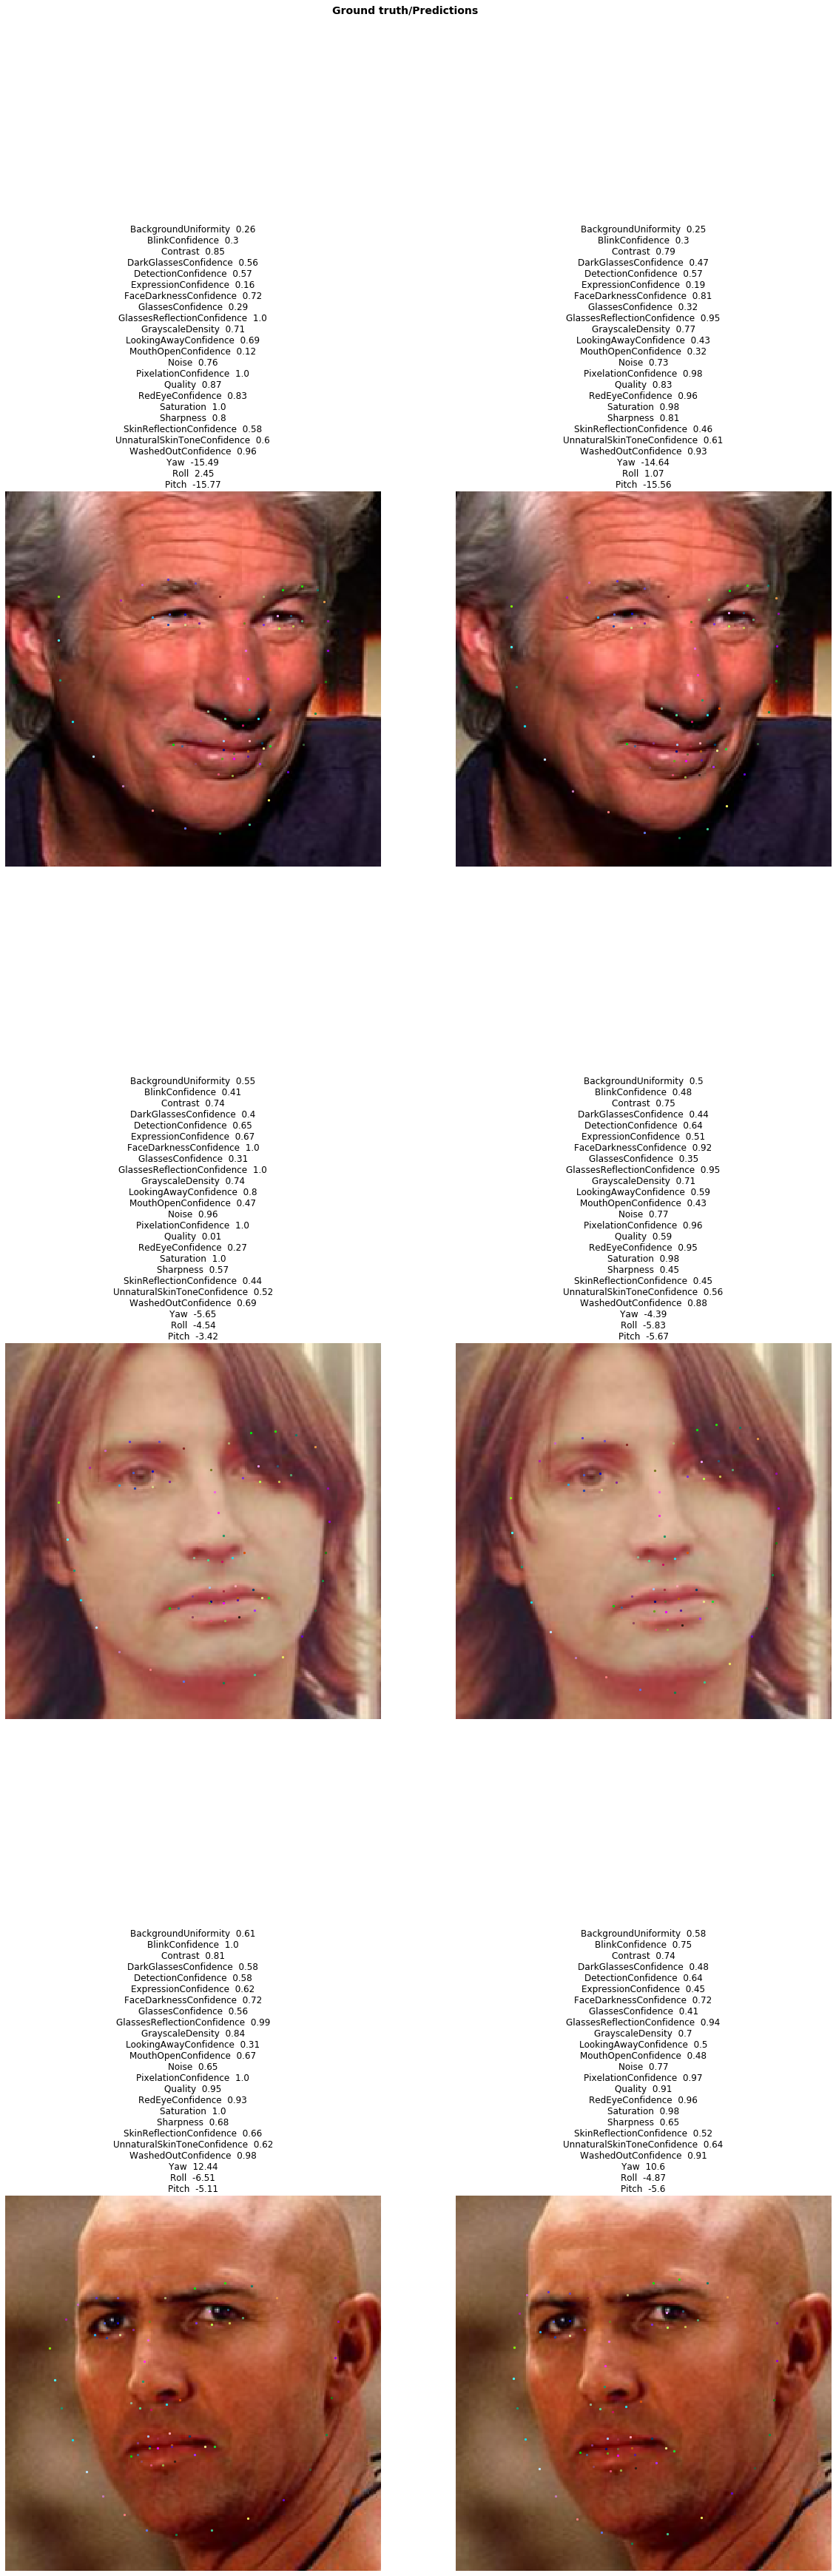

In [ ]:
show_results(learner, DatasetType.Train, rows=3)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MBack,MBlin,MCont,MDark,MDete,MExpr,MFace,MGlas,MGlas,MGray,MLook,MMout,MNois,MPixe,MQual,MRedE,MSatu,MShar,MSkin,MUnna,MWash,time
0,0.081341,0.033947,0.002041,0.002327,0.000000,0.018517,0.011062,0.153329,0.128102,0.088783,0.077234,0.053203,0.147918,0.064713,0.138383,0.138383,0.080196,0.135192,0.156610,0.094861,0.035254,0.135080,0.062746,0.017307,0.091509,0.073123,0.042317,0.064964,02:52
1,0.073395,0.036229,0.002161,0.002093,0.000000,0.018537,0.013438,0.151929,0.125594,0.087183,0.076557,0.052965,0.148793,0.067182,0.145818,0.145818,0.081695,0.136602,0.156005,0.095610,0.034517,0.134707,0.061667,0.013896,0.089872,0.075934,0.043428,0.064612,02:53
2,0.064847,0.035007,0.001813,0.001897,0.000000,0.018307,0.012991,0.151528,0.125708,0.086984,0.076467,0.053723,0.148634,0.067396,0.138895,0.138895,0.080402,0.138925,0.156378,0.095192,0.033540,0.135349,0.060385,0.012910,0.088481,0.076737,0.045235,0.064382,02:53
3,0.061400,0.030631,0.001364,0.001515,0.000000,0.017631,0.010121,0.151895,0.122828,0.084921,0.075735,0.051898,0.146138,0.064443,0.137950,0.137950,0.079526,0.139145,0.154340,0.094905,0.033086,0.131092,0.061611,0.011851,0.087866,0.076700,0.045318,0.063530,02:53
4,0.057364,0.031646,0.001705,0.001740,0.000000,0.018823,0.009377,0.151820,0.120752,0.083679,0.075549,0.052763,0.147209,0.067104,0.151177,0.151177,0.083207,0.139762,0.154710,0.097334,0.032566,0.128827,0.067065,0.010621,0.088701,0.075049,0.046960,0.065428,02:53
5,0.053957,0.025178,0.000988,0.001149,0.000000,0.016628,0.006413,0.147831,0.117846,0.080802,0.073677,0.050166,0.141984,0.062813,0.139615,0.139615,0.078284,0.138573,0.152401,0.092928,0.033332,0.125694,0.063656,0.010327,0.083715,0.076788,0.044173,0.063612,02:53
6,0.050517,0.029657,0.001550,0.001574,0.000000,0.018366,0.008167,0.150482,0.116567,0.078528,0.075224,0.052680,0.140658,0.070970,0.153022,0.153022,0.082711,0.139003,0.153996,0.095409,0.034480,0.126475,0.067736,0.010275,0.086480,0.076033,0.045956,0.064522,02:53
7,0.047050,0.025838,0.001258,0.001333,0.000000,0.016354,0.006892,0.146996,0.114277,0.075568,0.074099,0.051297,0.136046,0.059701,0.137578,0.137578,0.078973,0.138304,0.152609,0.091429,0.034179,0.123384,0.065651,0.009524,0.082696,0.073892,0.042321,0.062367,02:53
8,0.044835,0.020647,0.000594,0.000782,0.000000,0.014986,0.004284,0.144113,0.109384,0.069984,0.070829,0.046909,0.128249,0.061991,0.125305,0.125305,0.076700,0.134814,0.148004,0.088275,0.033283,0.116575,0.063953,0.009316,0.078774,0.072189,0.041194,0.061799,02:53
9,0.041597,0.026614,0.001526,0.001457,0.000000,0.015999,0.007632,0.146818,0.109403,0.069388,0.073535,0.050115,0.125967,0.061587,0.132451,0.132451,0.077939,0.137244,0.150526,0.088043,0.033677,0.117193,0.066021,0.009554,0.085337,0.070396,0.042916,0.061443,02:53


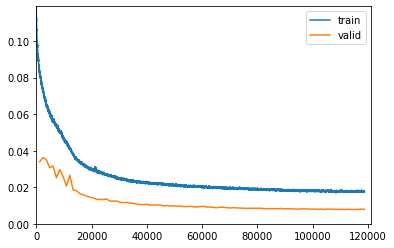

In [ ]:
fit_model(src, model, epochs=100, lr=1e-4, size=size, bs=8, transforms=custom_transforms, frozen_layers=[4], loss_weights=[1,1,1,1,1], eps=1e-1)

In [ ]:
save_torch_inference(learner.model, '../server/model.pth')

In [ ]:
fit_model(src, model, epochs=100, lr=1e-4, size=size, bs=8, transforms=custom_transforms, frozen_layers=[2,4], loss_weights=[0,0,0,1,0], eps=1e-1)

NameError: name 'fit_model' is not defined

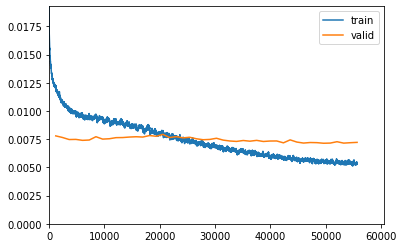

In [ ]:
fit_model(src, model, epochs=50, lr=1e-4, size=size, bs=8, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MBack,MBlin,MCont,MDark,MDete,MExpr,MFace,MGlas,MGlas,MGray,MLook,MMout,MNois,MPixe,MQual,MRedE,MSatu,MShar,MSkin,MUnna,MWash,time
0,0.014026,0.012290,0.001300,0.001880,0.000000,0.007066,0.002044,0.108438,0.077190,0.035532,0.046328,0.032643,0.070657,0.026921,0.083119,0.083119,0.044648,0.081823,0.066536,0.049458,0.036256,0.085868,0.039865,0.015521,0.047131,0.037919,0.023686,0.048203,02:50


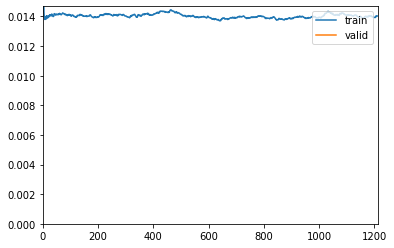

In [ ]:
fit_model(src, model, epochs=1, lr=1e-8, size=size, bs=8, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

In [ ]:
fit_model(src, model, epochs=50, lr=1e-4, size=size, bs=8, transforms=custom_transforms, frozen_layers=[0,4], loss_weights=[1,1,1,1,1], eps=1e-1)

In [ ]:
save_torch_inference(learner.model, '../server/model.pth')

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MBack,MBlin,MCont,MDark,MDete,MExpr,MFace,MGlas,MGlas,MGray,MLook,MMout,MNois,MPixe,MQual,MRedE,MSatu,MShar,MSkin,MUnna,MWash,time
0,0.011430,0.009245,0.000285,0.000411,0.000000,0.007112,0.001437,0.109264,0.082527,0.037748,0.048426,0.035362,0.065772,0.039664,0.078922,0.078922,0.051737,0.087981,0.066152,0.051209,0.034003,0.101695,0.042937,0.015367,0.056467,0.045328,0.025691,0.046926,02:53
1,0.011913,0.009247,0.000288,0.000410,0.000000,0.007075,0.001473,0.108978,0.079190,0.038265,0.050420,0.035346,0.065612,0.036967,0.089579,0.089579,0.049528,0.087914,0.066393,0.053295,0.035386,0.102029,0.040606,0.015449,0.059462,0.041379,0.022220,0.047273,02:54
2,0.010791,0.009055,0.000282,0.000399,0.000000,0.006866,0.001509,0.107811,0.082057,0.037188,0.046307,0.033946,0.076137,0.038442,0.078963,0.078963,0.048760,0.087244,0.062519,0.050984,0.033594,0.090428,0.038548,0.014931,0.057237,0.037268,0.021015,0.046639,02:53
3,0.009836,0.008025,0.000245,0.000345,0.000000,0.006286,0.001149,0.105374,0.075625,0.034928,0.043979,0.033798,0.061861,0.036905,0.076078,0.076078,0.046899,0.083855,0.061372,0.047772,0.033289,0.089728,0.038612,0.012579,0.052702,0.037229,0.019085,0.045845,02:54


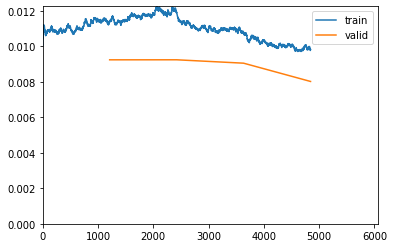

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
fit_model(src, model, epochs=5, lr=1e-4, size=size, bs=64, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MBack,MBlin,MCont,MDark,MDete,MExpr,MFace,MGlas,MGlas,MGray,MLook,MMout,MNois,MPixe,MQual,MRedE,MSatu,MShar,MSkin,MUnna,MWash,time
0,0.122127,0.065094,0.019324,0.035288,0.000000,0.007654,0.002828,0.110811,0.083603,0.048486,0.051503,0.038029,0.074966,0.054525,0.089622,0.089622,0.055924,0.089869,0.074679,0.052765,0.032320,0.092169,0.044067,0.015421,0.059755,0.056069,0.029728,0.047330,02:54
1,0.037785,0.064807,0.019267,0.035241,0.000000,0.007758,0.002541,0.112474,0.085942,0.046080,0.052385,0.038330,0.076805,0.047746,0.093032,0.093032,0.054820,0.090719,0.076998,0.052986,0.034434,0.093281,0.042337,0.016250,0.057191,0.053444,0.028220,0.047961,02:54
2,0.034262,0.065175,0.019292,0.035304,0.000000,0.007823,0.002756,0.112183,0.084511,0.048777,0.050737,0.038557,0.076731,0.047935,0.102008,0.102008,0.056183,0.089863,0.077812,0.054944,0.034613,0.100032,0.043620,0.016388,0.058198,0.051520,0.029080,0.048193,02:54
3,0.049115,0.064611,0.019246,0.035239,0.000000,0.007571,0.002555,0.111328,0.084765,0.044372,0.052600,0.038368,0.075143,0.044107,0.084531,0.084531,0.052901,0.088212,0.076196,0.052543,0.033669,0.096290,0.043210,0.015696,0.055469,0.046491,0.027443,0.050358,02:54
4,0.062053,0.064123,0.019329,0.035334,0.000000,0.007385,0.002075,0.110775,0.087242,0.044897,0.049854,0.037795,0.072519,0.044185,0.083491,0.083491,0.056673,0.087897,0.073044,0.051336,0.033156,0.093147,0.038179,0.015146,0.056192,0.050953,0.026097,0.047388,02:54
5,0.031184,0.063623,0.019153,0.035155,0.000000,0.007051,0.002264,0.109219,0.080902,0.043352,0.049340,0.037704,0.070607,0.042818,0.096841,0.096841,0.052784,0.086844,0.071062,0.049917,0.032369,0.093984,0.044560,0.015195,0.053188,0.046168,0.025235,0.046406,02:54
6,0.096799,0.063289,0.019329,0.035353,0.000000,0.006812,0.001796,0.107015,0.081265,0.041789,0.046972,0.036758,0.068806,0.042501,0.085964,0.085964,0.051373,0.085398,0.067429,0.049559,0.032268,0.090750,0.038979,0.013463,0.051916,0.049431,0.025558,0.046084,02:54
7,0.024363,0.062514,0.019144,0.035131,0.000000,0.006578,0.001661,0.106101,0.078632,0.042917,0.046943,0.036311,0.068109,0.040398,0.083090,0.083090,0.050734,0.084819,0.066799,0.048257,0.032800,0.089184,0.037834,0.014005,0.051017,0.045526,0.024261,0.045601,02:54
8,0.087082,0.062999,0.019392,0.035465,0.000000,0.006524,0.001619,0.105691,0.077763,0.041279,0.046063,0.036174,0.067575,0.040620,0.084472,0.084472,0.050136,0.084114,0.066179,0.048101,0.033127,0.088160,0.037187,0.014374,0.050634,0.044982,0.023644,0.045857,02:54
9,0.105352,0.062244,0.019111,0.035105,0.000000,0.006457,0.001571,0.105580,0.077372,0.041516,0.045765,0.036047,0.067449,0.039888,0.083215,0.083215,0.050388,0.084125,0.065725,0.047585,0.032599,0.088487,0.037690,0.013953,0.050671,0.044048,0.023496,0.045251,02:54


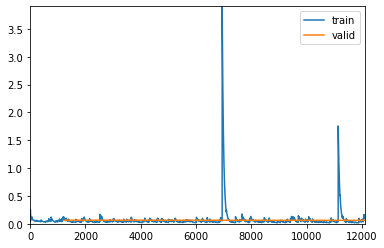

In [ ]:
learner.fit_one_cycle(10, 1e-4)

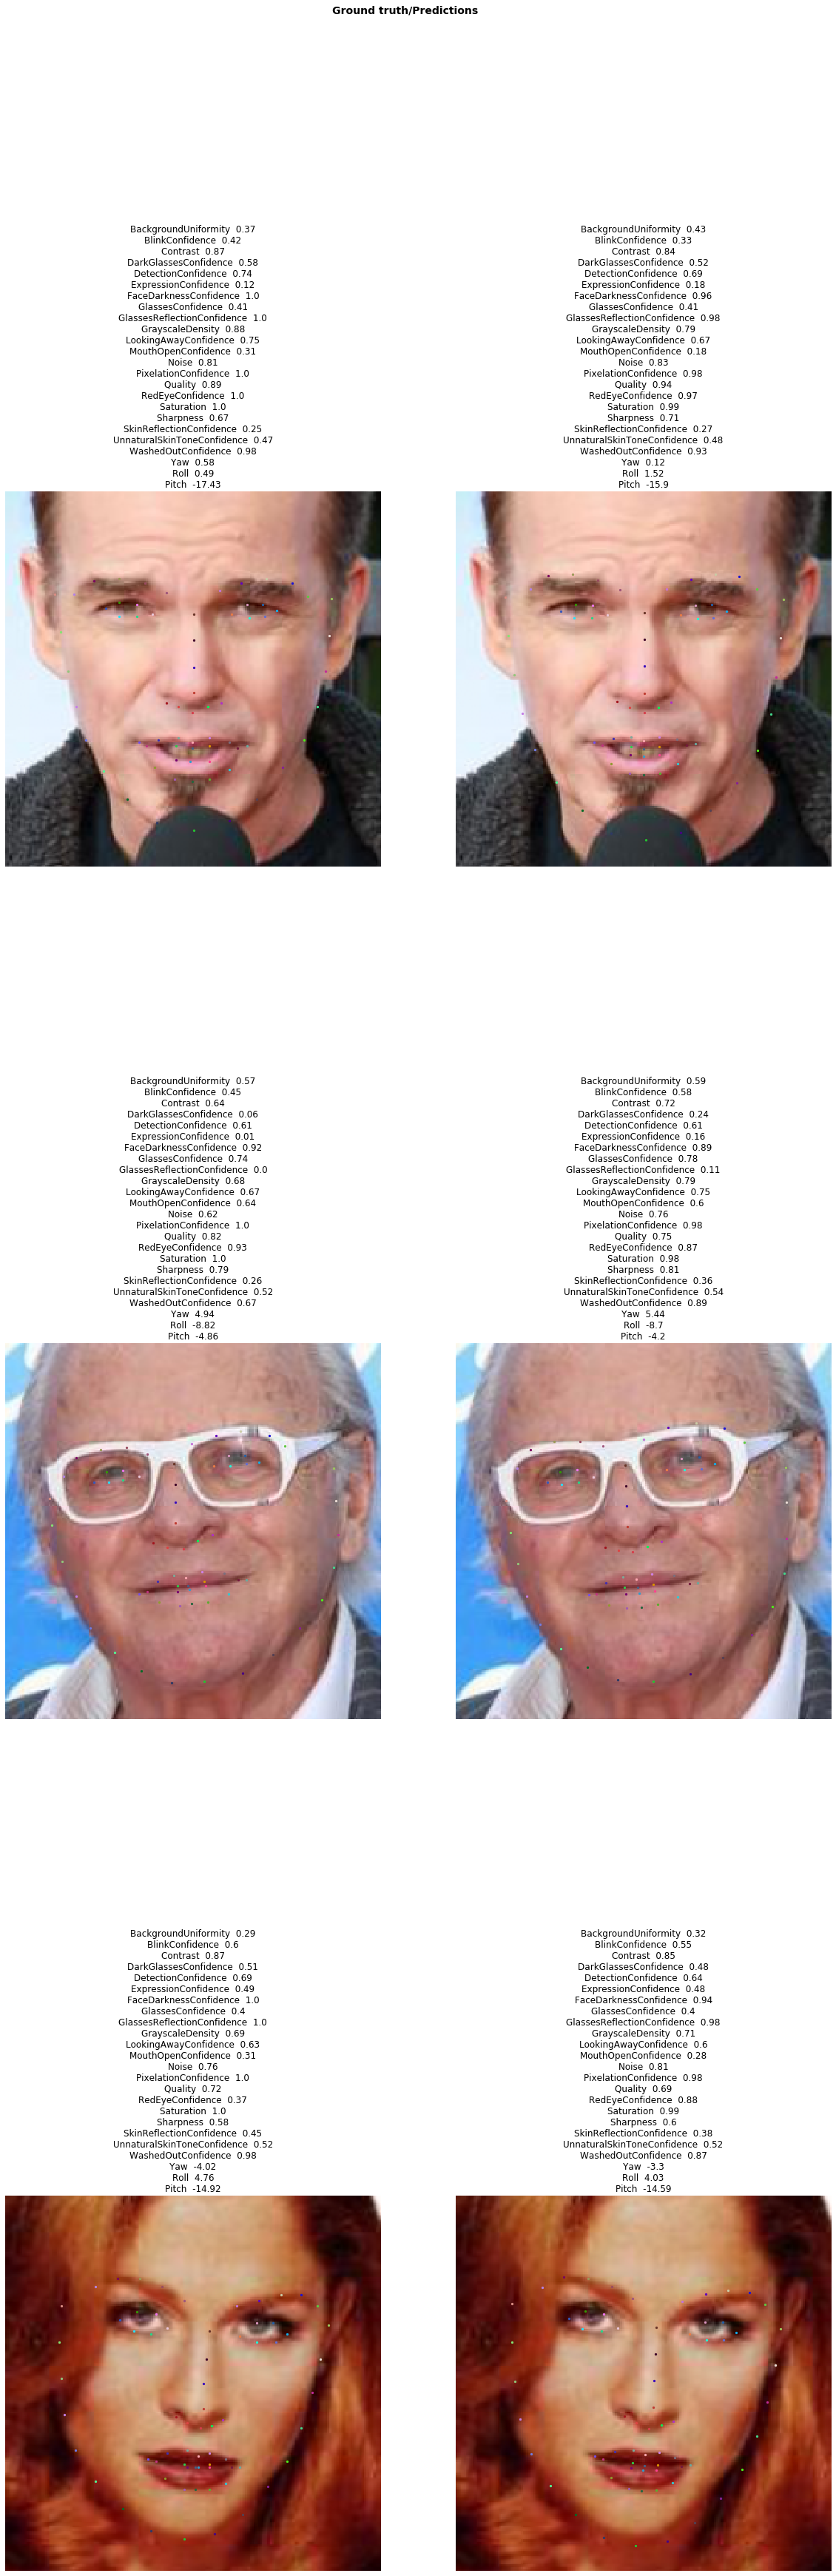

In [ ]:
show_results(learner, DatasetType.Valid, rows=3)

In [ ]:
save_torch_inference(learner.model, '../server/model.pth')

In [ ]:
loss = CustomLossBinVisual(nn.SmoothL1Loss(), [1,1,1,1,1])
data = create_data(src, size, bs=64, transforms=None)
learner = create_learner(data, model, loss_func=loss, callback_fns=[ShowGraph, AddLossMetrics], metrics=[])
freeze_layers(learner, [])

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MBack,MBlin,MCont,MDark,MDete,MExpr,MFace,MGlas,MGlas,MGray,MLook,MMout,MNois,MPixe,MQual,MRedE,MSatu,MShar,MSkin,MUnna,MWash,time
0,0.025965,0.062918,0.019386,0.035441,0.000000,0.006552,0.001539,0.104370,0.078416,0.035152,0.045217,0.035374,0.070001,0.036854,0.080350,0.080350,0.046591,0.083859,0.067523,0.046607,0.032782,0.089090,0.039313,0.013473,0.050184,0.037704,0.020228,0.045242,02:51
1,0.075699,0.062172,0.019163,0.035148,0.000000,0.006562,0.001299,0.104625,0.077734,0.035401,0.045348,0.034491,0.070455,0.037750,0.086906,0.086906,0.045830,0.082201,0.065961,0.048035,0.032923,0.097680,0.041171,0.014704,0.054042,0.036675,0.018698,0.045465,02:53
2,0.047496,0.061516,0.019105,0.035094,0.000000,0.006139,0.001177,0.103519,0.074818,0.034742,0.044366,0.033600,0.067910,0.036007,0.085947,0.085947,0.047008,0.080248,0.065174,0.045161,0.032532,0.089086,0.037809,0.012488,0.048091,0.035166,0.018266,0.044223,02:53
3,0.077698,0.061025,0.019095,0.035063,0.000000,0.005774,0.001094,0.101545,0.073244,0.032569,0.042074,0.033016,0.061498,0.033471,0.074146,0.074146,0.043929,0.078638,0.062548,0.044600,0.032677,0.085741,0.035269,0.012243,0.048322,0.033296,0.017723,0.043097,02:53
4,0.038759,0.061016,0.019088,0.035058,0.000000,0.005743,0.001127,0.101592,0.073066,0.033177,0.042048,0.033078,0.061365,0.034069,0.072887,0.072887,0.043981,0.078984,0.061189,0.044285,0.032607,0.085278,0.035077,0.011146,0.047434,0.033873,0.017438,0.043352,02:53


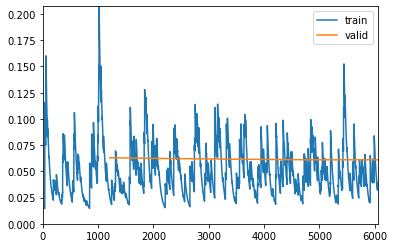

In [ ]:
learner.fit_one_cycle(5, 1e-4)

In [ ]:
save_torch_inference(learner.model, '../server/model.pth')

## GRAD CAM

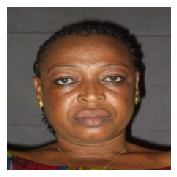

In [176]:
from facelib.core import plot
resize_one_img = lambda x, size: F.interpolate(x[None], size=size, mode='bilinear', align_corners=True)[0]

im = cv2.imread('../test_data/Face629.jpg')
im = im[:,:,[2,1,0]]
image = tensor(im).permute(2,0,1).float() / 255.
image = resize_one_img(image, [224,224])
Image(image).show()

In [177]:
# load_torch_inference(model, '../server/model5.pth', device=torch.device('cuda'))

In [178]:
class Hook():
    def __init__(self, model, hook_func, is_forward:bool=True, detach:bool=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = model.register_forward_hook if is_forward else model.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module, input, output):
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()

In [179]:
def _hook_inner(m,i,o): return o if isinstance(o,torch.Tensor) else o if is_listy(o) else list(o)
def hook_output (module:nn.Module, detach:bool=True, grad:bool=False)->Hook:
    return Hook(module, _hook_inner, detach=detach, is_forward=not grad)

In [180]:
model = model.eval()

In [181]:
def hooked_backward(model, cnn_layer, x_batch, cat=0):
    with hook_output(cnn_layer) as hook_a: # [1,256,7,7]
        with hook_output(cnn_layer, grad=True) as hook_g: # [1,1,256,7,7]
            fpts, bins, floats = model.eval()(x_batch) # [b,cats]
            bins[0,int(cat)].backward()
    return hook_a.stored, torch.cat(hook_g.stored, dim=0) # [1,256,7,7] x 2

In [184]:
hook_a,hook_g = hooked_backward(model, model.resnet, image.float().to('cuda')[None], cat=bin_names.index('MouthOpenConfidence'))

In [185]:
acts  = hook_a[0].cpu()
acts.shape

In [203]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [204]:
def show_heatmap(im, hm):
    _,ax = plt.subplots()
    Image(im).show(ax)
    hm = resize_one_img(hm[None], im.shape[1:])[0]
    ax.imshow(hm, alpha=0.6)

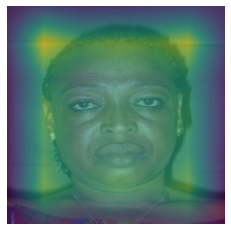

In [205]:
show_heatmap(image, avg_acts)

In [206]:
grad = hook_g[0].cpu() # [256,7,7]
grad_chan = grad.mean(dim=(1,2))[:,None,None] # [256,1,1]
grad_chan.shape

torch.Size([512, 1, 1])

In [207]:
mult = (acts*grad_chan).mean(0) # [7,7]
mult = F.relu((acts*grad_chan).sum(0))

In [208]:
# mult = 1 - mult # ???

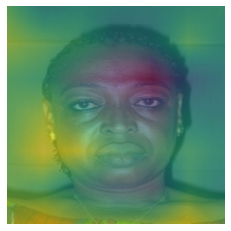

In [209]:
show_heatmap(image, mult)

# Saving Model Output

In [40]:
MODEL = model.to('cpu')

In [41]:
listify_1d = lambda tensor: [float(x) for x in tensor]
listify_2d = lambda tensor: [listify_1dtensor(batch) for batch in tensor]

In [43]:
important_bins = ['BlinkConfidence', 'ExpressionConfidence', 'LookingAwayConfidence', 'MouthOpenConfidence', 'FaceDarknessConfidence', 'GlassesConfidence']
bin_indexes = [bin_names.index(name) for name in important_bins]
bin_indexes

In [75]:
bs = 8
ds = data.train_ds
b, xs, ys, paths = 0, [], [], []

pred_losses = []
for i in progress_bar(list(range(len(ds)))):
    path, (x,y) = ds.items[i], ds[i]
    # create batches
    paths.append(path)
    xs.append(x.data[None])
    ys.append(y)
    b += 1
    if b != bs: continue
    # do something with batches
    bins_true = torch.cat([y.other_data[0][None] for y in ys], axis=0)
    images = torch.cat(xs, axis=0)
    if defaults.device == torch.device('cuda'):
        bins_true = bins_true.to('cuda')
        images = images.to('cuda')
    fpts, bins_pred, floats = MODEL(images)
    bins_true = bins_true[ : , bin_indexes ]
    bins_pred = bins_pred[ : , bin_indexes ]
    loss = nn.L1Loss(reduction='none')(bins_pred, bins_true) # [b,important_bins]
    for bin_pred, bin_true, bin_loss, path in zip(bins_pred, bins_true, loss, paths):
        bin_pred, bin_true, bin_loss = map(listify_1d, (bin_pred, bin_true, bin_loss))
        pred_losses.append( (path, bin_loss, bin_pred, bin_true) )
    b, xs, ys, paths = 0, [], [], []

output = {'bins': important_bins, 'output': pred_losses}

In [76]:
import json
with open('../data/outputs.json', 'w') as filepath:
    json.dump(output, filepath)

# Find only frontal faces in VGG2

In [41]:
means, stds = imagenet_stats

In [42]:
vgg_path = Path('/data/faces/VGG2/')
out_path = Path('../data/vgg_frontal_faces_hd/')
train_images_dir = vgg_path/'train'

In [43]:
from ipywidgets import widgets, Layout
from IPython.display import clear_output, display

bad_widget = widgets.Button(description='asd', button_style='danger')
good_widget = widgets.Button(description='asd', button_style='success')
err_widget = widgets.Button(description='asd', button_style='info')
display(widgets.HBox([bad_widget, good_widget, err_widget]))

In [44]:
bb_path = Path('/data/faces/VGG2/bb_landmark/loose_bb_train.csv')

num_bad, num_good, num_error = 0, 0, 0
for i,line in enumerate(progress_bar(open(bb_path).readlines()[1:])):
    im_name, x,y,w,h = line[:-1].split(',')
    x,y,w,h = map(int, [x,y,w,h])
    t,l,b,r = max(y,0),max(x,0),y+h,x+w
    im_path = train_images_dir/(im_name[1:-1]+'.jpg')
    image = open_image(im_path)
    cropped_image = Image(image.data[:,t:b,l:r])
    _,h,w = cropped_image.shape
    if h < 200:
        num_bad += 1
        continue
    
    try:
        _,_,(fpts, bins, floats) = learner.predict(cropped_image)
    except:
        num_error += 1
        continue
    
    yaw,roll,pitch = map(float, floats)
    if abs(yaw) < 10 and abs(roll) < 10 and abs(pitch) < 10 and h > 100:
        new_im_name = '_'.join(im_name[1:-1].split('/'))
        cropped_image.save(out_path/(new_im_name+'.jpg'))
        num_good += 1
#             cropped_image.show(title=f'{yaw,roll,pitch}')
    else:
        num_bad += 1
#             print('bad', num_bad, '/', i+1)
#         print('error', num_error, '/', i+1)
#         image.show(y=ImageBBox.create(*image.size, tensor([t,l,b,r])[None], scale=True))
    
    bad_widget.description = str(num_bad)
    good_widget.description = str(num_good)
    err_widget.description = str(num_error)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

# Example

tensor([-2.7154, -2.4391, -4.4439])

tensor([-2.7154, -2.4391, -4.4439])

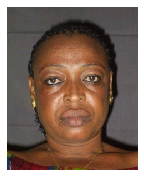

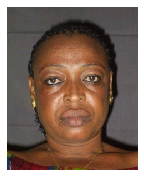

In [65]:
image = open_image('../test_data/Face629.jpg')
_,_,(fpts, bins, floats) = l.predict(image)
yaw,roll,pitch = floats
image.show()
floats

In [64]:
floats.shape

torch.Size([3])

torch.Size([3])

In [ ]:
from facelib.core import plot

In [ ]:
MODEL = model.to('cpu')

In [ ]:
import cv2

In [ ]:
im = cv2.imread('../test_data/Face629.jpg')
im = im[ 50:260 , 30:210 ]
im = im[:,:,[2,1,0]] # cv2.circle doesnt like this :(
h,w,c = im.shape

fpts, bins, floats = MODEL(tensor(im[:,:,[2,1,0]]).permute(2,0,1)[None] / 255.)
fpts, bins, floats = map(lambda x:x[0], [fpts, bins, floats])
fpts = (fpts+1)/2 * torch.tensor([h,w])[None]
fpts = [[int(y),int(x)] for y,x in fpts]
for y,x in fpts:
    im = cv2.circle(im, (x, y), radius=2, color=(255,0,0), thickness=1)
plot(im)